# Подготовка датасета для экпериментального метода аугментации данных при помощи модели Stable Diffusion

Для увеличения объема примеров обнаружения объектов в датасете, предлагаем метод который при помощи модели Stable Diffusion может в значительное количество раз увеличить объем, предлагая различного рода объекты. 

Для более лучшей генерации необходимо сделать файнтюнинг модели, для этого создадим собственный датасет для файнтюнинга. Возьмем пример датасета `lambdalabs/pokemon-blip-captions`, и наш датасет `object detection` в формате `COCO` и проведем `promt engeniring` чо бы сформировать датасет для файнтюнинга `Stable Diffusion`

In [ ]:
from datasets import load_dataset, Dataset, load_from_disk
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
sample = ds[0]

Using custom data configuration lambdalabs--pokemon-blip-captions-baa94796864cc987


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-baa94796864cc987/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
ds[240]['image'].size

(431, 431)

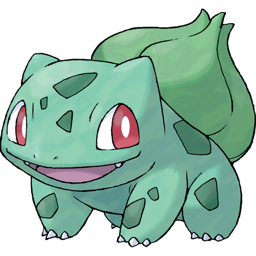

In [ ]:
sample['image'].resize((256, 256))

In [ ]:
sample["text"]

'a drawing of a green pokemon with red eyes'

Формат к которому необходимо привести датасет

```
{
'image':Pillow.Image,
'text':promt_text
}
```

Взглянем на наш датасет с `object detection`  в  формат COCO. 

In [18]:
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [19]:
ann_file = '../dataset/pipe/for_stable_diffusion/coco/crack/result.json'
dataset_path = '../dataset/pipe/for_stable_diffusion/coco/crack/images'

In [20]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Посмотрим какие категории есть

In [21]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO Категории: \n{}'.format(' '.join(nms)))

COCO Категории: 
Трещина


Взглянем, а есть ли вообще изображения на которых могут присудствовать несколько классов однавременно

In [22]:
catIds = coco.getCatIds(catNms=['Трещина', 'Разрыв', 'Свищ', 'Крип', 'Выход трубы из ряда']) # Получаем те id которые содержат выбранные нами категории
print(f'catIds: {catIds}')
imgIds = coco.getImgIds(catIds=catIds ) # получаем изображения где есть наши категории
print(f'imgIds: {imgIds}')
img = coco.loadImgs(imgIds[3])[0] # получаем первое изображение из выбранных
img_path = img["file_name"].replace("\\", "/") # делаем замену windows на linux пути 

catIds: [0]
imgIds: [0, 1, 2, 3]


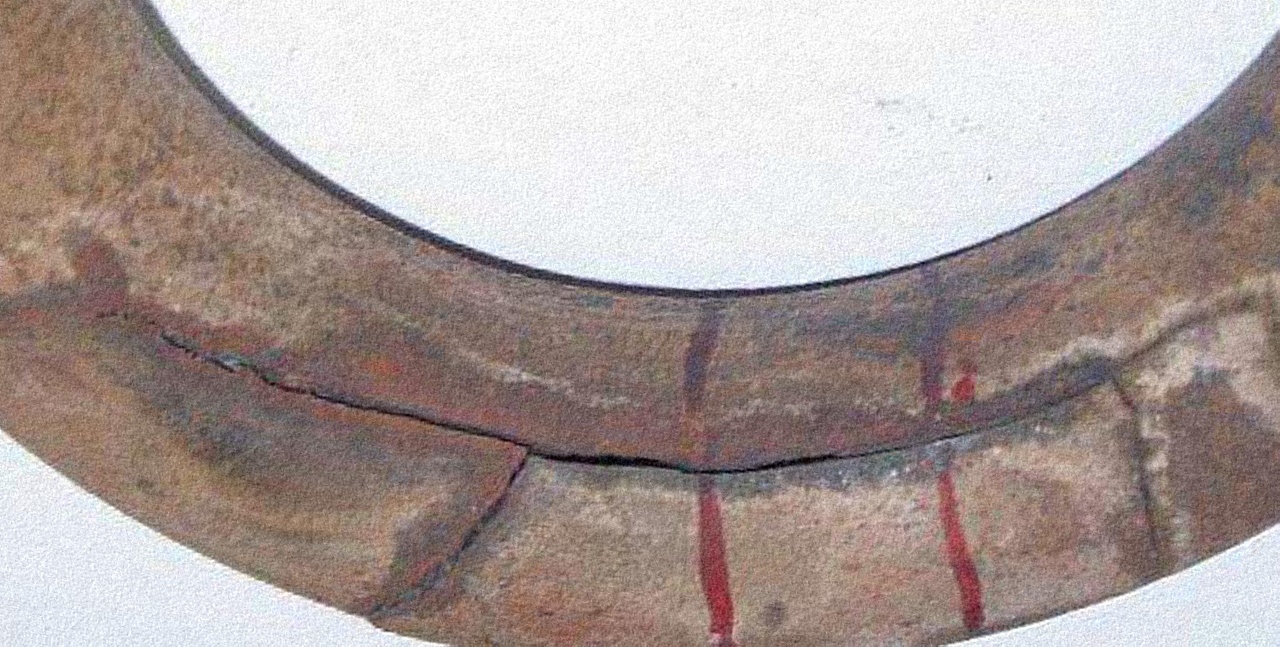

In [19]:
# im = Image.open(f"{dataset_path}/{img_path}")
# im

im = Image.open('../dataset/pipe/old_pipe/project-15-at-2022-08-09-10-07-0f0f5133/images/71_5_5944.jpg')
im

anns=[{'id': 3, 'image_id': 3, 'category_id': 0, 'segmentation': [], 'bbox': [334, 652, 237, 105], 'ignore': 0, 'iscrowd': 0, 'area': 24885}]


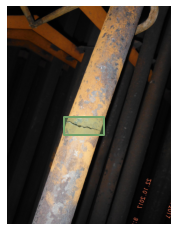

In [24]:
plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print(f'anns={anns}')
coco.showAnns(anns, draw_bbox=True)

(-0.5, 236.5, 104.5, -0.5)

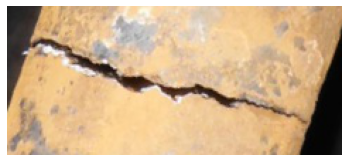

In [25]:
x, y, w,h = [int(x) for x in anns[0]['bbox']]
im_np = np.array(im)[y:y+h, x:x+w]
plt.imshow(im_np); plt.axis('off')

In [26]:
imgs = coco.imgs

In [27]:
imgs = list(imgs.values())
len(imgs)

4

In [28]:
labelid2text = {0:'crack'} # Конвертация id класса в название

In [29]:
PROMT_TEMAPLTE = [
    'Photo of a <OBJ> on a metal pipe',
    '<OBJ> on a metal pipe'
]

In [30]:
def generate_promt(obj:str):
    return [x.replace('<OBJ>', obj) for x in PROMT_TEMAPLTE]

In [31]:
SCALE_PADDING_PERCENT = 0.2

In [32]:


img_org = Image.open(f"{dataset_path}/{img_path}")
org_w, org_h = img_org.size
print(f'original_size: {(org_w, org_h)}')
padding_w, padding_h = int(org_w*SCALE_PADDING_PERCENT), int(org_h*SCALE_PADDING_PERCENT)
print(f'(padding_w, padding_h) = {(padding_w, padding_h)}')


x, y, w,h = [int(x) for x in anns[0]['bbox']]

print(f'bbox={[x, y, w,h]}')
center_point = (x + w // 2, y + h // 2)

max_side = max(w,h)
print(f'max_side={max_side}')


delta_w, delta_h = max_side - w, max_side - h
delta = delta_w  if delta_h == 0 else delta_h

print(f'delta={delta}')

square_bbox = [
    x - delta_w // 2,
    y - delta_h // 2,
    max_side,
    max_side
]
print(f'square_bbox = {square_bbox}')



original_size: (960, 1280)
(padding_w, padding_h) = (192, 256)
bbox=[334, 652, 237, 105]
max_side=237
delta=132
square_bbox = [334, 586, 237, 237]


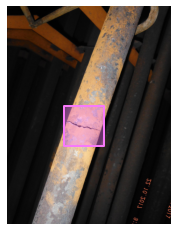

In [33]:
anns=[{'id': 0, 'image_id': 0, 'category_id': 0, 'segmentation': [], 'bbox': square_bbox, 'ignore': 0, 'iscrowd': 0, 'area': square_bbox[2]*square_bbox[3]}]
plt.imshow(im); plt.axis('off')
# annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
# anns = coco.loadAnns(annIds/home/peter-pc/Desktop/repos/stable-diffusion/stablediffusion-finetune/dataset/pipe/old_pipe/project-15-at-2022-08-09-10-07-0f0f5133/images)
# print(f'anns={anns}')
coco.showAnns(anns, draw_bbox=True)

In [34]:
padding = int(max_side * SCALE_PADDING_PERCENT)
print(f'padding={padding}')
square_bbox_with_padding = [
    square_bbox[0] - padding,
    square_bbox[1] - padding,
    square_bbox[2] + padding * 2,
    square_bbox[3] + padding * 2
]

print(f'square_bbox_with_padding={square_bbox_with_padding}')

padding=47
square_bbox_with_padding=[287, 539, 331, 331]


anns = [{'id': 0, 'image_id': 0, 'category_id': 0, 'segmentation': [], 'bbox': [287, 539, 331, 331], 'ignore': 0, 'iscrowd': 0, 'area': 109561}]


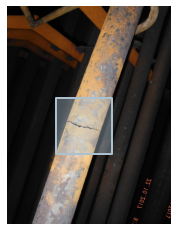

In [35]:

anns = [{'id': 0, 'image_id': 0, 'category_id': 0, 'segmentation': [], 'bbox': square_bbox_with_padding, 'ignore': 0, 'iscrowd': 0, 'area': square_bbox_with_padding[2]*square_bbox_with_padding[3]}]
print(f'anns = {anns}')
plt.imshow(im); plt.axis('off')
# annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
# anns = coco.loadAnns(annIds)
# print(f'anns={anns}')
coco.showAnns(anns, draw_bbox = True)

In [36]:
# x1, y1 = square_bbox_with_padding[0], square_bbox_with_padding[1]
x1, y1 = (square_bbox_with_padding[0], square_bbox_with_padding[1])
print(f'x1, y1 = {(x1, y1)}')

x2, y2 = (x1 + square_bbox_with_padding[2], y1 + square_bbox_with_padding[3])
print(((x1, y1), (x2, y2)))
new_offset_x = 0
new_offset_y = 0
if x2 > org_w:
    print('x2 > org_w')
    new_offset_x = org_w - x2
if y2 > org_h:
    print('y2 > org_h')
    new_offset_y = org_h - y2
if x1 < 0:
    print('x1 < 0')
    new_offset_x = -x1
if y1 < 0:
    print('y1 < 0')
    new_offset_y = -y1
    

x1 += new_offset_x
y1 += new_offset_y

print(x1, y1)
print(new_offset_x, new_offset_y)

square_bbox_with_padding[0] = x1
square_bbox_with_padding[1] = y1

x1, y1 = (287, 539)
((287, 539), (618, 870))
287 539
0 0


anns = [{'id': 0, 'image_id': 0, 'category_id': 0, 'segmentation': [], 'bbox': [287, 539, 331, 331], 'ignore': 0, 'iscrowd': 0, 'area': 109561}]


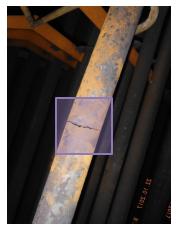

In [37]:

anns = [{'id': 0, 'image_id': 0, 'category_id': 0, 'segmentation': [], 'bbox': square_bbox_with_padding, 'ignore': 0, 'iscrowd': 0, 'area': square_bbox_with_padding[2]*square_bbox_with_padding[3]}]
print(f'anns = {anns}')
plt.imshow(im); plt.axis('off')
# annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
# anns = coco.loadAnns(annIds)
# print(f'anns={anns}')
coco.showAnns(anns, draw_bbox = True)

# Создание DS

In [1]:
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# ann_file = '../dataset/pipe/new_pipe/project-14-at-2022-08-09-10-03-1117d404/result.json'
# dataset_path = '../dataset/pipe/new_pipe/project-14-at-2022-08-09-10-03-1117d404/images'
ann_file = '../dataset/pipe/old_pipe/project-15-at-2022-08-09-10-07-0f0f5133/result.json'
dataset_path = '../dataset/pipe/old_pipe/project-15-at-2022-08-09-10-07-0f0f5133/images'

In [3]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO Категории: \n{}'.format(' '.join(nms)))

COCO Категории: 
Выход трубы из ряда Крип Разрыв трубы Свищ Трещина


In [5]:
# catIds = coco.getCatIds(catNms=['Трещина', 'Разрыв', 'Свищ', 'Крип', 'Выход трубы из ряда']) # Получаем те id которые содержат выбранные нами категории
catIds = coco.getCatIds(catNms=['Трещина', 'Разрыв', 'Свищ'])
print(f'catIds: {catIds}')
imgIds = coco.getImgIds(catIds=catIds ) # получаем изображения где есть наши категории
print(f'imgIds: {imgIds}')

catIds: [3, 4]
imgIds: [64, 65, 66, 46, 47, 48, 26, 62, 63]


In [6]:
imgs = coco.imgs

In [7]:
imgs = list(imgs.values())

In [8]:
len(imgs)

3054

In [9]:
labelid2text = {0:'exit from row', 1:'creep', 2:'gap', 3:'fistula', 4:'crack'} # Конвертация id класса в название

In [10]:
PROMT_TEMAPLTE = [
    'Photo of a <OBJ> on a metal pipe',
    '<OBJ> on a metal pipe'
]

In [11]:
def generate_promt(obj:str):
    return [x.replace('<OBJ>', obj) for x in PROMT_TEMAPLTE]

In [12]:
SCALE_PADDING_PERCENT = 0.5

In [13]:
new_dataset = []
for img in tqdm(imgs):
    ann_id = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    ann_img = coco.loadAnns(ann_id)
    img_path = img["file_name"].replace("\\", "/") # делаем замену windows на linux пути
    print(img_path)
    img_org = Image.open(f"{dataset_path}/{img_path}")
    org_w, org_h = img_org.size
    padding_w, padding_h = int(org_w*SCALE_PADDING_PERCENT), int(org_h*SCALE_PADDING_PERCENT)
    
    for ann in ann_img:
        x, y, w,h = [int(x) for x in ann['bbox']]
        center_point = (x + w // 2, y + h // 2)
        max_side = max(w,h)

        delta_w, delta_h = max_side - w, max_side - h
        delta = delta_w  if delta_h == 0 else delta_h

        square_bbox = [
            x - delta_w // 2,
            y - delta_h // 2,
            max_side,
            max_side
        ]

        padding = int(max_side * SCALE_PADDING_PERCENT)
        square_bbox_with_padding = [
            square_bbox[from datasets import Dataset
dataset = Dataset.from_list(new_dataset) # Загрузим датасет из списка в объект 

dataset.save_to_disk('../dataset/promt_datasets/3') # Сохраним на диск датасе0] - padding,
            square_bbox[1] - padding,
            square_bbox[2] + padding * 2,
            square_bbox[3] + padding * 2
        ]
        
        x1, y1 = (square_bbox_with_padding[0], square_bbox_with_padding[1])
        x2, y2 = (x1 + square_bbox_with_padding[2], y1 + square_bbox_with_padding[3])

        new_offset_x = 0
        new_offset_y = 0
        if x2 > org_w:
            new_offset_x = org_w - x2
        if y2 > org_h:
            new_offset_y = org_h - y2
        if x1 < 0:
            new_offset_x = -x1
        if y1 < 0:
            new_offset_y = -y1


        x1 += new_offset_x
        y1 += new_offset_y

        square_bbox_with_padding[0] = x1
        square_bbox_with_padding[1] = y1
        
        crop_x1, crop_y1 = square_bbox_with_padding[0], square_bbox_with_padding[1]
        crop_x2, crop_y2 = crop_x1 + square_bbox_with_padding[2], crop_y1 + square_bbox_with_padding[3]
        
        
        im_np = np.array(img_org)[ crop_y1:crop_y2, crop_x1:crop_x2]
        cr_img = Image.fromarray(im_np)
        generated_promt = generate_promt(labelid2text[ann['category_id']])
        for promt in generated_promt:
            new_dataset.append({
                'text': promt,
                'image': cr_img
            })

  0%|          | 6/3054 [00:00<00:56, 54.39it/s]

30_5_836f.jpg
30_4_208b.jpg
30_3_ec8d.jpg
30_2_4baf.jpg
30_1_19e7.jpg
29_9_4301.jpg
29_8_2966.jpg
29_7_bf26.jpg
29_6_fcdf.jpg
29_5_5eba.jpg
29_4_da77.jpg
29_3_1c25.jpg


  1%|          | 19/3054 [00:00<00:51, 58.74it/s]

29_1_7dc4.jpg
29_2_5753.jpg
27_3_e5dd.jpg
27_1_3934.jpg
22_8_4c4d.jpg
22_7_e551.jpg
22_6_5baf.jpg
22_5_f73b.jpg
22_4_1b6b.jpg
22_3_8fd9.jpg
22_2_3f25.jpg
22_1_6c5e.jpg


  1%|          | 31/3054 [00:00<00:58, 51.82it/s]

16_17de.jpg
201_3_66ec.jpg
200_8_ea49.jpg
32_7_72ff.jpg
10_8_6c73.jpg
71_1bc0.jpg
83_1f42.jpg
113_daee.jpg
120_f8a4.jpg
5_1_2b7c.jpg


  1%|          | 37/3054 [00:00<01:09, 43.57it/s]

5_3_4fe3.jpg
5_5_a606.jpg
5_7_4446.jpg
5_9_4517.jpg
8_2_3e48.jpg
32_1_af09.jpg
71_7_0e2f.jpg


  2%|▏         | 49/3054 [00:00<01:00, 49.37it/s]

71_3_5870.jpg
71_1_2ae4.jpg
87_8_7f48.jpg
87_6_91f5.jpg
87_4_2166.jpg
200_2_0cf7.jpg
200_4_cb64.jpg
200_6_eefc.jpg
201_1_5893.jpg
201_5_049f.jpg
201_7_02f4.jpg


  2%|▏         | 55/3054 [00:01<01:12, 41.36it/s]

201_9_daf6.jpg
202_2_4d86.jpg
202_4_095d.jpg
202_6_90db.jpg
202_8_7dba.jpg
203_1_eeb6.jpg
203_3_b7d9.jpg


  2%|▏         | 65/3054 [00:01<01:14, 40.13it/s]

203_5_eca2.jpg
203_9_f4e3.jpg
203_7_9c81.jpg
236_1_4bb8.jpg
236_3_4294.jpg
236_5_060e.jpg
236_7_d2e7.jpg
236_9_cd38.jpg
15_39fb.jpg


  3%|▎         | 77/3054 [00:01<01:01, 48.20it/s]

237_8_1548.jpg
237_6_ccd1.jpg
237_4_2140.jpg
237_2_91a3.jpg
235_8_917b.jpg
235_6_25b1.jpg
235_4_1f0c.jpg
235_2_9526.jpg
211_2_4c19.jpg
209_9_7cee.jpg
209_7_12c5.jpg
209_5_c80b.jpg
209_3_cd89.jpg
209_1_df35.jpg


  3%|▎         | 90/3054 [00:01<00:56, 52.81it/s]

208_8_32eb.jpg
208_6_b6c9.jpg
208_4_f38e.jpg
208_2_ffae.jpg
207_9_bb5c.jpg
207_7_0a09.jpg
207_5_9295.jpg
207_3_f36e.jpg
207_1_fd04.jpg
206_8_ebc3.jpg
206_6_ca1e.jpg


  3%|▎         | 104/3054 [00:02<00:49, 59.11it/s]

206_4_8134.jpg
206_2_55e3.jpg
205_9_87ac.jpg
205_7_9bb6.jpg
205_5_61d5.jpg
205_3_77db.jpg
205_1_c8ff.jpg
204_8_4e9a.jpg
204_6_825c.jpg
204_4_6501.jpg
204_2_edfe.jpg
147_8_3d55.jpg
147_6_a3ed.jpg
147_4_74ae.jpg


  4%|▍         | 120/3054 [00:02<00:43, 67.51it/s]

147_2_0fe1.jpg
146_9_a08f.jpg
146_7_9cad.jpg
146_5_1958.jpg
146_3_94bf.jpg
146_1_601e.jpg
145_8_6d14.jpg
145_6_b4c7.jpg
145_4_75f8.jpg
145_2_ec04.jpg
144_9_6e84.jpg
144_7_b13f.jpg
144_5_83e4.jpg
144_3_c18c.jpg
144_1_9f9c.jpg
143_8_e8bc.jpg


  4%|▍         | 128/3054 [00:02<00:43, 68.02it/s]

143_6_d4e6.jpg
143_4_8956.jpg
143_2_d755.jpg
142_9_0066.jpg
142_7_83ba.jpg
142_5_85ad.jpg
142_3_8bd9.jpg
142_1_3fdd.jpg
141_8_31a0.jpg
141_6_168a.jpg
141_4_dc87.jpg
141_2_2b6f.jpg


  5%|▍         | 142/3054 [00:02<00:51, 56.47it/s]

140_9_765b.jpg
140_7_edac.jpg
140_5_d602.jpg
140_3_b38e.jpg
140_1_4a34.jpg
139_8_d739.jpg
139_6_558e.jpg
139_4_ee84.jpg
139_2_15d7.jpg
138_9_0024.jpg


  5%|▌         | 154/3054 [00:02<00:50, 56.87it/s]

138_7_f5c8.jpg
138_5_e71c.jpg
138_3_8d90.jpg
138_1_9601.jpg
137_8_2780.jpg
137_6_4891.jpg
137_4_3878.jpg
137_2_e99f.jpg
136_9_42ac.jpg
136_7_76e9.jpg
136_5_b9b4.jpg
136_3_ff1d.jpg


  5%|▌         | 167/3054 [00:03<00:50, 56.92it/s]

136_1_7a67.jpg
135_8_47d5.jpg
135_6_df21.jpg
135_4_cbd8.jpg
135_2_dc66.jpg
134_9_4d5b.jpg
134_7_eca0.jpg
134_5_b848.jpg
134_3_f931.jpg
134_1_c454.jpg
133_8_c06c.jpg
133_6_171a.jpg


  6%|▌         | 182/3054 [00:03<00:45, 63.02it/s]

133_4_d9ab.jpg
133_2_4310.jpg
132_9_71fa.jpg
132_7_ef3c.jpg
132_5_ff2c.jpg
132_3_fb48.jpg
132_1_a3c7.jpg
131_8_988b.jpg
131_6_f623.jpg
131_4_85a3.jpg
131_2_1dba.jpg
130_9_c1a7.jpg
130_7_f20b.jpg
130_5_7857.jpg


  6%|▋         | 196/3054 [00:03<00:44, 64.27it/s]

130_3_e091.jpg
130_1_e925.jpg
129_8_7509.jpg
129_6_7e0e.jpg
129_4_1fe1.jpg
129_2_c1ac.jpg
128_9_e2f9.jpg
128_7_a178.jpg
128_5_c3ae.jpg
128_3_e77e.jpg
128_1_4533.jpg
127_8_1a44.jpg
127_6_b72e.jpg
127_4_5caf.jpg


  7%|▋         | 215/3054 [00:03<00:36, 77.53it/s]

127_2_eb6e.jpg
124_9_fae6.jpg
124_7_897c.jpg
124_5_9ff4.jpg
124_3_9619.jpg
124_1_bbbc.jpg
123_8_b691.jpg
123_6_19a7.jpg
123_4_9f13.jpg
123_2_f54d.jpg
122_9_2f9f.jpg
122_7_5564.jpg
122_5_5082.jpg
122_3_a366.jpg
122_1_bf24.jpg
121_8_5eb0.jpg
121_6_14d7.jpg
121_4_fdd5.jpg
121_2_c5ec.jpg


  7%|▋         | 223/3054 [00:03<00:37, 76.30it/s]

120_9_fb6f.jpg
120_7_7db4.jpg
120_5_e84e.jpg
120_3_d7b4.jpg
120_1_5202.jpg
91_2_f3a4.jpg
90_9_9069.jpg
90_7_c59d.jpg
90_5_6d57.jpg
90_3_9e24.jpg
90_1_cc72.jpg
89_8_ba78.jpg
89_6_4c71.jpg
89_4_7ccc.jpg
89_2_3350.jpg


  8%|▊         | 239/3054 [00:04<00:38, 73.99it/s]

88_9_7446.jpg
88_7_0606.jpg
88_5_9fbc.jpg
88_3_9e04.jpg
88_1_6b56.jpg
87_2_3b94.jpg
86_9_6aa0.jpg
86_7_13b0.jpg
86_5_e8d5.jpg
86_3_7226.jpg
86_1_c671.jpg
85_8_761a.jpg
85_6_2272.jpg


  8%|▊         | 256/3054 [00:04<00:38, 71.89it/s]

85_4_bafb.jpg
85_2_2e22.jpg
84_9_b637.jpg
84_7_bcbc.jpg
84_5_fb9f.jpg
84_3_4006.jpg
84_1_b32b.jpg
83_8_3375.jpg
83_6_2ed0.jpg
83_4_4369.jpg
83_2_a981.jpg
82_9_219d.jpg
82_7_5cce.jpg
82_5_573b.jpg
82_3_47d6.jpg
82_1_2e98.jpg


  9%|▉         | 272/3054 [00:04<00:39, 69.91it/s]

81_8_5f62.jpg
81_6_9f4b.jpg
81_4_a8d4.jpg
81_2_d5a3.jpg
80_9_3b9a.jpg
80_7_e666.jpg
80_5_122d.jpg
80_3_e8a7.jpg
80_1_960f.jpg
79_8_c444.jpg
79_6_be1b.jpg
79_4_27da.jpg
79_2_d0cd.jpg
78_9_0e42.jpg


  9%|▉         | 280/3054 [00:04<00:41, 66.57it/s]

78_7_12fc.jpg
78_5_154e.jpg
78_3_31fb.jpg
78_1_216a.jpg
77_8_ff0f.jpg
77_6_419c.jpg
77_4_773b.jpg
77_2_5fea.jpg
72_8_ba3b.jpg
72_6_25bd.jpg
72_4_11c4.jpg
72_2_b5fe.jpg
71_9_78c6.jpg
71_5_5944.jpg


 10%|▉         | 295/3054 [00:04<00:43, 62.83it/s]

52_8_1a6e.jpg
52_6_12c6.jpg
52_4_28b5.jpg
52_2_bfd0.jpg
51_9_8645.jpg
51_7_4a34.jpg
51_5_83b4.jpg
51_3_b458.jpg
51_1_6bb4.jpg
50_8_180a.jpg
50_6_077f.jpg


 10%|█         | 309/3054 [00:05<00:47, 57.62it/s]

50_4_fe52.jpg
50_2_4434.jpg
49_9_be83.jpg
49_7_1a79.jpg
49_5_0330.jpg
49_3_b538.jpg
49_1_b936.jpg
48_8_ce09.jpg
48_6_e327.jpg
48_4_9c4b.jpg
48_2_7374.jpg


 10%|█         | 315/3054 [00:05<00:48, 56.84it/s]

47_9_109c.jpg
47_7_6dfe.jpg
47_5_1039.jpg
47_3_6b02.jpg
47_1_9af1.jpg
46_8_1087.jpg
46_6_95d2.jpg
46_4_172b.jpg
46_2_cdd6.jpg
45_9_3154.jpg
45_7_a9ac.jpg


 11%|█         | 327/3054 [00:05<00:52, 51.51it/s]

45_5_6608.jpg
45_3_a1f3.jpg
45_1_659e.jpg
44_8_14aa.jpg
44_6_bc66.jpg
44_4_465c.jpg
44_2_214c.jpg
34_8_4482.jpg
34_6_1121.jpg
34_4_f440.jpg


 11%|█         | 339/3054 [00:05<00:54, 50.07it/s]

34_2_5c79.jpg
32_9_e281.jpg
32_5_a267.jpg
32_3_94b6.jpg
28_5_b553.jpg
28_3_65e3.jpg
28_1_5447.jpg
27_8_083b.jpg
27_6_119b.jpg
27_4_3deb.jpg
27_2_6899.jpg


 11%|█▏        | 351/3054 [00:06<00:53, 50.70it/s]

10_6_e82f.jpg
10_4_a3f3.jpg
10_2_bc4d.jpg
9_9_75d5.jpg
9_7_5a37.jpg
9_5_5fb0.jpg
9_3_8c6f.jpg
9_1_a3a3.jpg
8_8_4424.jpg
8_6_4163.jpg
8_4_beff.jpg


 12%|█▏        | 357/3054 [00:06<01:03, 42.65it/s]

4_8_5c8b.jpg
4_6_db27.jpg
4_4_8d26.jpg
4_2_22bd.jpg
3_9_a7a2.jpg
3_7_859a.jpg
3_5_b335.jpg
3_3_5d07.jpg


 12%|█▏        | 367/3054 [00:06<01:01, 43.41it/s]

3_1_8de4.jpg
1_8_c458.jpg
1_6_1a50.jpg
1_4_1b67.jpg
1_2_39bd.jpg
243_41ec.jpg
241_d58c.jpg
239_b3f5.jpg
237_0da6.jpg
235_4fd2.jpg


 13%|█▎        | 382/3054 [00:06<00:48, 55.48it/s]

234_0677.jpg
232_ff3e.jpg
229_9b06.jpg
227_6b76.jpg
225_61d0.jpg
222_097d.jpg
220_d595.jpg
217_9a6e.jpg
215_6348.jpg
213_f678.jpg
211_6e59.jpg
208_6d0c.jpg
206_d3ae.jpg
204_2603.jpg
202_013e.jpg


 13%|█▎        | 394/3054 [00:06<00:48, 54.33it/s]

200_8ffc.jpg
198_e740.jpg
196_6e5e.jpg
194_3641.jpg
192_a931.jpg
190_bb4f.jpg
188_1839.jpg
186_7b8f.jpg
184_e328.jpg
182_1c9c.jpg


 13%|█▎        | 408/3054 [00:07<00:44, 59.62it/s]

180_f44d.jpg
178_753c.jpg
176_5fff.jpg
174_6146.jpg
172_fd3c.jpg
170_fb34.jpg
168_7d84.jpg
166_d06e.jpg
164_3a44.jpg
162_c03c.jpg
160_53b2.jpg
158_c245.jpg
156_e96a.jpg


 14%|█▎        | 416/3054 [00:07<00:41, 63.03it/s]

154_6388.jpg
152_6a9c.jpg
150_ab0f.jpg
148_79f0.jpg
146_8e4c.jpg
144_1de3.jpg
142_665e.jpg
140_a6ae.jpg
138_52da.jpg
136_8db3.jpg
134_a397.jpg
132_af8a.jpg
130_431a.jpg
128_dc65.jpg


 14%|█▍        | 430/3054 [00:07<00:40, 64.54it/s]

124_9754.jpg
122_b86b.jpg
119_fc94.jpg
117_7b76.jpg
115_0dd1.jpg
111_0a64.jpg
109_8d6a.jpg
107_9162.jpg
105_d798.jpg
103_dfa0.jpg
101_867e.jpg
99_b916.jpg
97_22b3.jpg


 15%|█▍        | 445/3054 [00:07<00:39, 65.86it/s]

95_0fdb.jpg
93_bed2.jpg
91_7a72.jpg
89_3f15.jpg
87_96a4.jpg
85_7f2f.jpg
81_70be.jpg
79_60f8.jpg
77_e79d.jpg
75_f8a3.jpg
73_8caa.jpg
70_877f.jpg
68_e706.jpg
66_7f86.jpg


 15%|█▌        | 459/3054 [00:07<00:44, 58.97it/s]

64_52e4.jpg
62_5f0d.jpg
60_0cb1.jpg
58_b666.jpg
56_e060.jpg
54_128a.jpg
52_ba69.jpg
50_0c0a.jpg
48_2001.jpg
46_d6fd.jpg
44_997c.jpg


 15%|█▌        | 471/3054 [00:08<00:47, 54.86it/s]

41_a554.jpg
38_5157.jpg
32_617d.jpg
31_01b9.jpg
29_655b.jpg
27_3ff0.jpg
25_f00b.jpg
23_9364.jpg
21_bf37.jpg
19_0f72.jpg
17_f08a.jpg
12_be33.jpg


 16%|█▌        | 477/3054 [00:08<00:54, 47.24it/s]

10_ebdc.jpg
8_cb63.jpg
4_6947.jpg
1_387d.jpg
img_0396_600_c084.jpg
img_0144_600_032e.jpg
img_0274_600_5001.jpg
img_0303_600_afb4.jpg


 16%|█▌        | 487/3054 [00:08<00:54, 46.92it/s]

img_0094_300_1acc.jpg
img_0060_600_fd1e.jpg
img_0244_300_0db4.jpg
img_0520_600_f189.jpg
img_0029_600_14f9.jpg
img_0429_600_1294.jpg
img_0099_300_cf5d.jpg
img_0066_600_50be.jpg
img_0282_600_649b.jpg
img_0486_600_8d4b.jpg


 16%|█▋        | 497/3054 [00:08<00:53, 47.42it/s]

img_0079_300_f11a.jpg
img_0240_300_d9c5.jpg
img_0378_600_1f31.jpg
img_0290_600_88b5.jpg
img_0230_600_d13d.jpg
img_0141_600_8b40.jpg
img_0452_600_94e0.jpg
img_0559_600_3aa4.jpg
img_0098_300_b7cc.jpg
img_0155_300_e889.jpg


 17%|█▋        | 507/3054 [00:09<00:53, 47.38it/s]

img_0208_300_a41a.jpg
img_0230_300_8f69.jpg
img_0263_300_cadc.jpg
img_0360_600_acd8.jpg
img_0404_600_c9cd.jpg
img_0154_600_1aa4.jpg
img_0325_600_d13f.jpg
img_0174_600_06bf.jpg
img_0240_600_f38b.jpg
img_0478_600_d95c.jpg


 17%|█▋        | 519/3054 [00:09<00:52, 48.28it/s]

img_0018_300_1e9c.jpg
img_0466_600_5fca.jpg
img_0394_600_2e4d.jpg
img_0244_600_b629.jpg
img_0282_300_9dcb.jpg
img_0085_300_d413.jpg
img_0051_600_0e51.jpg
img_0408_600_0520.jpg
img_0367_600_910f.jpg
img_0176_600_9ad8.jpg


 17%|█▋        | 529/3054 [00:09<00:52, 48.29it/s]

img_0027_300_17a8.jpg
img_0234_600_a7c9.jpg
img_0078_600_3839.jpg
img_0301_600_9301.jpg
img_0235_300_fb91.jpg
img_0440_600_8d52.jpg
img_0199_300_785c.jpg
img_0297_300_cbba.jpg
img_0385_600_25ea.jpg
img_0003_300_1d05.jpg


 18%|█▊        | 539/3054 [00:09<00:52, 48.26it/s]

img_0188_300_fc73.jpg
img_0142_300_ab7c.jpg
img_0518_600_9ddc.jpg
img_0227_300_b463.jpg
img_0115_300_0908.jpg
img_0390_600_b918.jpg
img_0199_600_5465.jpg
img_0225_300_a1b1.jpg
img_0159_300_1b86.jpg
img_0468_600_0500.jpg


 18%|█▊        | 549/3054 [00:09<00:53, 47.10it/s]

img_0034_600_8af7.jpg
img_0328_600_6329.jpg
img_0344_600_35a4.jpg
img_0243_600_96f8.jpg
img_0209_300_1882.jpg
img_0104_600_ae00.jpg
img_0467_600_7658.jpg
img_0249_600_ccb0.jpg
img_0033_300_670f.jpg
img_0555_600_641b.jpg


 18%|█▊        | 561/3054 [00:10<00:50, 49.14it/s]

img_0418_600_1e3b.jpg
img_0308_600_332f.jpg
img_0217_300_0e90.jpg
img_0095_300_a5ef.jpg
img_0056_600_74c4.jpg
img_0031_600_b9a0.jpg
img_0541_600_93b6.jpg
img_0315_600_2f13.jpg
img_0193_300_0b38.jpg
img_0550_600_1e27.jpg
img_0445_600_4c74.jpg


 19%|█▊        | 571/3054 [00:10<00:51, 48.61it/s]

img_0431_600_63e9.jpg
img_0011_600_ab96.jpg
img_0475_600_c550.jpg
img_0363_600_6f3e.jpg
img_0092_300_e6b6.jpg
img_0232_300_694c.jpg
img_0166_600_8d4f.jpg
img_0451_600_a652.jpg
img_0216_300_67ad.jpg
img_0292_600_574a.jpg


 19%|█▉        | 577/3054 [00:10<00:50, 49.13it/s]

img_0495_600_7712.jpg
img_0084_600_fc82.jpg
img_0435_600_aabd.jpg
img_0517_600_3548.jpg
img_0156_300_f73f.jpg
img_0575_600_b7d0.jpg
img_0088_600_a8f8.jpg
img_0436_600_8a03.jpg
img_0087_300_8f9c.jpg
img_0160_300_ff1a.jpg


 19%|█▉        | 587/3054 [00:10<00:51, 47.56it/s]

img_0100_300_438f.jpg
img_0352_600_56b6.jpg
img_0152_300_b592.jpg
img_0234_300_2c66.jpg
img_0490_600_9080.jpg
img_0283_600_2cc2.jpg
img_0585_600_280b.jpg
img_0086_600_37a7.jpg
img_0194_300_498d.jpg
img_0579_600_6d7d.jpg


 20%|█▉        | 597/3054 [00:10<00:51, 48.01it/s]

img_0102_300_14a5.jpg
img_0457_600_a4ec.jpg
img_0259_300_c690.jpg
img_0309_600_4225.jpg
img_0196_300_5d33.jpg
img_0046_600_b2c0.jpg
img_0039_300_6f82.jpg
img_0266_600_34db.jpg
img_0275_300_8b33.jpg
img_0357_600_4afa.jpg


 20%|█▉        | 609/3054 [00:11<00:49, 49.02it/s]

img_0464_600_b3ae.jpg
img_0290_300_ce37.jpg
img_0002_300_7fa2.jpg
img_0250_600_4c9e.jpg
img_0251_600_3d75.jpg
img_0162_600_c7e2.jpg
img_0410_600_b050.jpg
img_0490_600_9080.jpg
img_0600_600_f4e3.jpg
img_0597_600_9094.jpg


 20%|██        | 623/3054 [00:11<00:43, 55.88it/s]

img_0596_600_24c5.jpg
img_0595_600_507e.jpg
img_0592_600_8c27.jpg
img_0591_600_5ee1.jpg
img_0590_600_4fba.jpg
img_0589_600_f0d8.jpg
img_0584_600_b773.jpg
img_0578_600_2a38.jpg
img_0577_600_4907.jpg
img_0576_600_7cc6.jpg
img_0575_600_b7d0.jpg
img_0574_600_1b48.jpg
img_0573_600_b090.jpg
img_0572_600_f6de.jpg


 21%|██        | 635/3054 [00:11<00:45, 53.04it/s]

img_0570_600_c559.jpg
img_0568_600_e338.jpg
img_0566_600_5c75.jpg
img_0563_600_e1ce.jpg
img_0562_600_1a88.jpg
img_0561_600_afc9.jpg
img_0560_600_d0a7.jpg
img_0558_600_2b03.jpg
img_0556_600_e44a.jpg
img_0552_600_23e6.jpg
img_0550_600_1e27.jpg


 21%|██▏       | 649/3054 [00:11<00:42, 56.93it/s]

img_0548_600_7d10.jpg
img_0546_600_c926.jpg
img_0541_600_93b6.jpg
img_0538_600_4020.jpg
img_0536_600_d379.jpg
img_0535_600_a25e.jpg
img_0533_600_0770.jpg
img_0531_600_b2d6.jpg
img_0530_600_7882.jpg
img_0529_600_717c.jpg
img_0527_600_5f37.jpg
img_0526_600_1de4.jpg
img_0524_600_1f3b.jpg
img_0523_600_577b.jpg


 22%|██▏       | 661/3054 [00:12<00:42, 55.71it/s]

img_0522_600_2872.jpg
img_0521_600_b5d0.jpg
img_0520_600_f189.jpg
img_0519_600_62ba.jpg
img_0516_600_921a.jpg
img_0515_600_3ba2.jpg
img_0514_600_d618.jpg
img_0513_600_a4c0.jpg
img_0512_600_a3d3.jpg
img_0511_600_52cf.jpg
img_0509_600_774e.jpg


 22%|██▏       | 667/3054 [00:12<00:44, 54.06it/s]

img_0508_600_1089.jpg
img_0507_600_eb73.jpg
img_0505_600_0228.jpg
img_0504_600_bec9.jpg
img_0502_600_0822.jpg
img_0499_600_25fc.jpg
img_0498_600_bad3.jpg
img_0497_600_8189.jpg
img_0496_600_bc9f.jpg
img_0495_600_7712.jpg


 22%|██▏       | 679/3054 [00:12<00:47, 49.58it/s]

img_0494_600_a87b.jpg
img_0492_600_0c4f.jpg
img_0489_600_2705.jpg
img_0487_600_0f52.jpg
img_0486_600_8d4b.jpg
img_0485_600_0763.jpg
img_0483_600_0e49.jpg
img_0482_600_78e5.jpg
img_0481_600_186d.jpg
img_0480_600_7524.jpg


 23%|██▎       | 689/3054 [00:12<00:49, 47.61it/s]

img_0478_600_d95c.jpg
img_0477_600_d093.jpg
img_0476_600_fc63.jpg
img_0473_600_eb16.jpg
img_0472_600_750a.jpg
img_0471_600_46ed.jpg
img_0470_600_df40.jpg
img_0468_600_0500.jpg
img_0465_600_0699.jpg
img_0463_600_0e54.jpg


 23%|██▎       | 699/3054 [00:12<00:49, 47.42it/s]

img_0462_600_b954.jpg
img_0461_600_7a7e.jpg
img_0460_600_0377.jpg
img_0459_600_03ed.jpg
img_0458_600_37f4.jpg
img_0457_600_a4ec.jpg
img_0456_600_b283.jpg
img_0455_600_dc92.jpg
img_0454_600_742a.jpg
img_0453_600_b8ef.jpg


 23%|██▎       | 709/3054 [00:13<00:50, 46.89it/s]

img_0452_600_94e0.jpg
img_0451_600_a652.jpg
img_0450_600_8f4f.jpg
img_0449_600_349f.jpg
img_0448_600_865c.jpg
img_0447_600_b194.jpg
img_0446_600_928d.jpg
img_0445_600_4c74.jpg
img_0444_600_4b9e.jpg
img_0442_600_ae0f.jpg


 24%|██▎       | 719/3054 [00:13<00:49, 47.17it/s]

img_0441_600_84f2.jpg
img_0440_600_8d52.jpg
img_0439_600_85eb.jpg
img_0438_600_8dbf.jpg
img_0437_600_f05a.jpg
img_0436_600_8a03.jpg
img_0434_600_3d43.jpg
img_0433_600_10bc.jpg
img_0432_600_f4a5.jpg
img_0430_600_be71.jpg


 24%|██▍       | 729/3054 [00:13<00:50, 46.17it/s]

img_0429_600_1294.jpg
img_0428_600_2588.jpg
img_0426_600_ba96.jpg
img_0425_600_57f3.jpg
img_0424_600_24a8.jpg
img_0423_600_d57f.jpg
img_0422_600_db61.jpg
img_0419_600_840c.jpg
img_0418_600_1e3b.jpg
img_0416_600_7af3.jpg


 24%|██▍       | 739/3054 [00:13<00:50, 45.83it/s]

img_0415_600_1dd6.jpg
img_0413_600_88a6.jpg
img_0412_600_9f9a.jpg
img_0411_600_ef91.jpg
img_0409_600_6a7a.jpg
img_0408_600_0520.jpg
img_0406_600_5a9f.jpg
img_0405_600_c43f.jpg
img_0403_600_e97a.jpg


 25%|██▍       | 749/3054 [00:13<00:49, 46.99it/s]

img_0402_600_47c8.jpg
img_0400_600_34d5.jpg
img_0399_600_ea5e.jpg
img_0398_600_7800.jpg
img_0397_600_44c5.jpg
img_0396_600_c084.jpg
img_0395_600_1e87.jpg
img_0394_600_2e4d.jpg
img_0393_600_00f9.jpg
img_0392_600_ad39.jpg


 25%|██▍       | 759/3054 [00:14<00:48, 47.12it/s]

img_0391_600_7b71.jpg
img_0390_600_b918.jpg
img_0389_600_82c3.jpg
img_0388_600_cfc7.jpg
img_0387_600_30f8.jpg
img_0386_600_312d.jpg
img_0385_600_25ea.jpg
img_0383_600_e438.jpg
img_0382_600_8e1f.jpg
img_0381_600_9458.jpg


 25%|██▌       | 769/3054 [00:14<00:47, 47.66it/s]

img_0380_600_cc39.jpg
img_0379_600_fa5f.jpg
img_0378_600_1f31.jpg
img_0377_600_4e46.jpg
img_0376_600_0ac6.jpg
img_0375_600_dea8.jpg
img_0374_600_ab27.jpg
img_0373_600_e458.jpg
img_0371_600_5a82.jpg
img_0370_600_6686.jpg


 26%|██▌       | 779/3054 [00:14<00:47, 47.93it/s]

img_0369_600_0eca.jpg
img_0368_600_ad22.jpg
img_0367_600_910f.jpg
img_0365_600_dd55.jpg
img_0363_600_6f3e.jpg
img_0362_600_733f.jpg
img_0361_600_3243.jpg
img_0357_600_4afa.jpg
img_0356_600_1672.jpg
img_0355_600_4cf4.jpg


 26%|██▌       | 791/3054 [00:14<00:44, 50.49it/s]

img_0354_600_1a44.jpg
img_0353_600_1f90.jpg
img_0352_600_56b6.jpg
img_0351_600_9bc8.jpg
img_0350_600_252f.jpg
img_0348_600_2b5b.jpg
img_0347_600_5b94.jpg
img_0346_600_2493.jpg
img_0345_600_877e.jpg
img_0343_600_625f.jpg
img_0342_600_f8ba.jpg


 26%|██▌       | 797/3054 [00:14<00:46, 48.71it/s]

img_0341_600_c926.jpg
img_0339_600_6cbe.jpg
img_0338_600_7671.jpg
img_0337_600_63df.jpg
img_0335_600_a13f.jpg
img_0334_600_5238.jpg
img_0333_600_1acb.jpg
img_0332_600_dcdc.jpg
img_0331_600_fdb1.jpg
img_0330_600_65da.jpg


 26%|██▋       | 807/3054 [00:15<00:46, 48.11it/s]

img_0329_600_b589.jpg
img_0327_600_bdba.jpg
img_0326_600_7fa9.jpg
img_0324_600_1ba9.jpg
img_0323_600_581a.jpg
img_0322_600_1c90.jpg
img_0321_600_fb49.jpg
img_0320_600_0e51.jpg
img_0318_600_4368.jpg
img_0316_600_6a59.jpg


 27%|██▋       | 817/3054 [00:15<00:46, 47.87it/s]

img_0314_600_8e71.jpg
img_0313_600_3e65.jpg
img_0312_600_6da1.jpg
img_0311_600_a33f.jpg
img_0310_600_4d0f.jpg
img_0309_600_4225.jpg
img_0308_600_332f.jpg
img_0307_600_5016.jpg
img_0306_600_8912.jpg
img_0305_600_4fc6.jpg
img_0304_600_2583.jpg


 27%|██▋       | 830/3054 [00:15<00:40, 55.23it/s]

img_0303_600_afb4.jpg
img_0302_600_c358.jpg
img_0299_600_524a.jpg
img_0294_600_b7ce.jpg
img_0291_600_0a82.jpg
img_0290_600_88b5.jpg
img_0288_600_5ec5.jpg
img_0287_600_b72b.jpg
img_0282_600_649b.jpg
img_0281_600_edce.jpg
img_0278_600_4a29.jpg
img_0277_600_e5a4.jpg
img_0276_600_8fae.jpg
img_0274_600_5001.jpg
img_0271_600_7a44.jpg
img_0270_600_fe37.jpg


 28%|██▊       | 846/3054 [00:15<00:35, 63.06it/s]

img_0267_600_bf80.jpg
img_0266_600_34db.jpg
img_0263_600_91f3.jpg
img_0261_600_b51e.jpg
img_0254_600_f6c2.jpg
img_0252_600_25eb.jpg
img_0248_600_9826.jpg
img_0244_600_b629.jpg
img_0239_600_c3af.jpg
img_0236_600_b401.jpg
img_0235_600_3f94.jpg
img_0234_600_a7c9.jpg


 28%|██▊       | 860/3054 [00:16<00:37, 58.19it/s]

img_0229_600_7e06.jpg
img_0226_600_99c7.jpg
img_0221_600_4586.jpg
img_0220_600_cb5a.jpg
img_0219_600_a826.jpg
img_0215_600_c0c9.jpg
img_0213_600_f765.jpg
img_0210_600_b130.jpg
img_0209_600_34e9.jpg
img_0206_600_3d26.jpg
img_0199_600_5465.jpg
img_0198_600_86bb.jpg


 29%|██▊       | 872/3054 [00:16<00:38, 57.37it/s]

img_0196_600_164e.jpg
img_0195_600_90ab.jpg
img_0194_600_fb41.jpg
img_0193_600_b85a.jpg
img_0192_600_27fc.jpg
img_0190_600_e7e9.jpg
img_0189_600_a418.jpg
img_0188_600_22f3.jpg
img_0187_600_7573.jpg
img_0185_600_b8ea.jpg
img_0184_600_fa3d.jpg


 29%|██▉       | 884/3054 [00:16<00:38, 55.95it/s]

img_0183_600_a719.jpg
img_0181_600_03bd.jpg
img_0179_600_4fa9.jpg
img_0177_600_e968.jpg
img_0176_600_9ad8.jpg
img_0175_600_8fc7.jpg
img_0174_600_06bf.jpg
img_0171_600_169c.jpg
img_0170_600_e313.jpg
img_0169_600_fab6.jpg
img_0168_600_509c.jpg
img_0167_600_2d6b.jpg


 29%|██▉       | 896/3054 [00:16<00:40, 53.36it/s]

img_0165_600_0dad.jpg
img_0164_600_abd4.jpg
img_0163_600_5202.jpg
img_0162_600_c7e2.jpg
img_0160_600_fa6b.jpg
img_0159_600_e3a5.jpg
img_0158_600_9493.jpg
img_0156_600_76a2.jpg
img_0155_600_6a55.jpg
img_0154_600_1aa4.jpg
img_0153_600_edbe.jpg


 30%|██▉       | 902/3054 [00:16<00:42, 51.17it/s]

img_0152_600_ca8f.jpg
img_0151_600_c235.jpg
img_0150_600_9194.jpg
img_0149_600_8113.jpg
img_0148_600_b397.jpg
img_0147_600_d7d0.jpg
img_0146_600_8ebf.jpg
img_0145_600_03b7.jpg
img_0144_600_032e.jpg
img_0143_600_ea14.jpg
img_0142_600_d5e8.jpg


 30%|██▉       | 914/3054 [00:17<00:40, 53.30it/s]

img_0141_600_8b40.jpg
img_0140_600_212b.jpg
img_0139_600_ad89.jpg
img_0138_600_2eb3.jpg
img_0137_600_8380.jpg
img_0136_600_8454.jpg
img_0134_600_0b27.jpg
img_0133_600_d0cd.jpg
img_0131_600_cdcc.jpg
img_0129_600_6e40.jpg
img_0128_600_f6d0.jpg
img_0127_600_eaa9.jpg
img_0126_600_4df6.jpg


 30%|███       | 927/3054 [00:17<00:40, 53.10it/s]

img_0124_600_1b99.jpg
img_0123_600_33a4.jpg
img_0122_600_e01c.jpg
img_0121_600_46ce.jpg
img_0120_600_279e.jpg
img_0119_600_5f33.jpg
img_0118_600_3d8b.jpg
img_0117_600_8d70.jpg
img_0116_600_4804.jpg
img_0115_600_2a88.jpg


 31%|███       | 939/3054 [00:17<00:42, 49.58it/s]

img_0112_600_439e.jpg
img_0111_600_dd5f.jpg
img_0110_600_ab1f.jpg
img_0109_600_f0f0.jpg
img_0107_600_59e1.jpg
img_0105_600_945a.jpg
img_0104_600_ae00.jpg
img_0103_600_5ce8.jpg
img_0102_600_f903.jpg
img_0101_600_c567.jpg


 31%|███       | 949/3054 [00:17<00:42, 49.59it/s]

img_0099_600_5fb3.jpg
img_0098_600_c13b.jpg
img_0097_600_e2c0.jpg
img_0096_600_5fb9.jpg
img_0095_600_52ba.jpg
img_0094_600_fd30.jpg
img_0093_600_b48f.jpg
img_0091_600_0d90.jpg
img_0090_600_8ee0.jpg
img_0089_600_d38e.jpg
img_0088_600_a8f8.jpg


 31%|███▏      | 960/3054 [00:17<00:42, 49.81it/s]

img_0087_600_5fcb.jpg
img_0086_600_37a7.jpg
img_0085_600_2d63.jpg
img_0084_600_fc82.jpg
img_0082_600_36e1.jpg
img_0081_600_4808.jpg
img_0078_600_3839.jpg
img_0077_600_058c.jpg
img_0075_600_d32e.jpg
img_0074_600_0213.jpg
img_0072_600_53e3.jpg


 32%|███▏      | 973/3054 [00:18<00:39, 52.88it/s]

img_0071_600_038d.jpg
img_0070_600_1efc.jpg
img_0068_600_1a86.jpg
img_0065_600_2e8f.jpg
img_0062_600_8299.jpg
img_0061_600_98f6.jpg
img_0060_600_fd1e.jpg
img_0059_600_3d6e.jpg
img_0058_600_3d1b.jpg
img_0057_600_968b.jpg
img_0056_600_74c4.jpg
img_0054_600_017c.jpg


 32%|███▏      | 986/3054 [00:18<00:38, 54.35it/s]

img_0053_600_83e0.jpg
img_0052_600_4dec.jpg
img_0051_600_0e51.jpg
img_0050_600_f7fc.jpg
img_0049_600_0d9e.jpg
img_0048_600_8161.jpg
img_0047_600_43ef.jpg
img_0045_600_7fd3.jpg
img_0043_600_83c7.jpg
img_0042_600_56f6.jpg
img_0040_600_33f7.jpg
img_0039_600_f408.jpg


 33%|███▎      | 993/3054 [00:18<00:36, 56.24it/s]

img_0038_600_053f.jpg
img_0037_600_cb61.jpg
img_0035_600_39bd.jpg
img_0034_600_8af7.jpg
img_0033_600_2cf2.jpg
img_0030_600_6007.jpg
img_0029_600_14f9.jpg
img_0028_600_beb3.jpg
img_0027_600_18de.jpg
img_0025_600_f706.jpg
img_0023_600_ee75.jpg
img_0022_600_2419.jpg


 33%|███▎      | 1006/3054 [00:18<00:36, 56.01it/s]

img_0021_600_19a2.jpg
img_0019_600_93f8.jpg
img_0018_600_e164.jpg
img_0017_600_c76c.jpg
img_0016_600_7d0c.jpg
img_0014_600_82aa.jpg
img_0012_600_87c3.jpg
img_0010_600_fa05.jpg
img_0009_600_26f8.jpg
img_0008_600_7dd7.jpg
img_0007_600_ffd3.jpg
img_0006_600_8c1c.jpg
img_0005_600_fa5d.jpg
img_0004_600_3642.jpg


 33%|███▎      | 1020/3054 [00:18<00:32, 62.37it/s]

img_0003_600_494e.jpg
img_0002_600_e508.jpg
img_0001_600_2c03.jpg
img_0300_300_5ccd.jpg
img_0299_300_82cd.jpg
img_0294_300_b5c9.jpg
img_0293_300_8714.jpg
img_0289_300_d1d5.jpg
img_0286_300_b3fb.jpg
img_0285_300_7f87.jpg
img_0284_300_c901.jpg
img_0283_300_3373.jpg
img_0280_300_2782.jpg


 34%|███▍      | 1034/3054 [00:19<00:34, 58.77it/s]

img_0278_300_c8a3.jpg
img_0277_300_c3bd.jpg
img_0276_300_8aae.jpg
img_0275_300_8b33.jpg
img_0272_300_25d3.jpg
img_0271_300_76de.jpg
img_0270_300_8fe4.jpg
img_0269_300_87b0.jpg
img_0268_300_51e8.jpg
img_0267_300_1019.jpg
img_0266_300_850c.jpg
img_0264_300_bb8b.jpg


 34%|███▍      | 1047/3054 [00:19<00:36, 55.06it/s]

img_0260_300_4699.jpg
img_0259_300_c690.jpg
img_0253_300_0ece.jpg
img_0250_300_dbe0.jpg
img_0249_300_8d15.jpg
img_0246_300_442b.jpg
img_0245_300_c716.jpg
img_0244_300_0db4.jpg
img_0243_300_85d4.jpg
img_0242_300_89ea.jpg
img_0240_300_d9c5.jpg


 34%|███▍      | 1053/3054 [00:19<00:38, 52.42it/s]

img_0239_300_e8f0.jpg
img_0238_300_cfaa.jpg
img_0237_300_6dd8.jpg
img_0236_300_9461.jpg
img_0235_300_fb91.jpg
img_0234_300_2c66.jpg
img_0233_300_f8cf.jpg
img_0232_300_694c.jpg
img_0231_300_f628.jpg
img_0229_300_d2b7.jpg


 35%|███▍      | 1065/3054 [00:19<00:40, 49.69it/s]

img_0224_300_5372.jpg
img_0226_300_ac19.jpg
img_0227_300_b463.jpg
img_0223_300_83d6.jpg
img_0222_300_06a0.jpg
img_0220_300_5a04.jpg
img_0219_300_0b08.jpg
img_0218_300_6c05.jpg
img_0217_300_0e90.jpg
img_0216_300_67ad.jpg


 35%|███▌      | 1075/3054 [00:20<00:40, 48.28it/s]

img_0215_300_0f08.jpg
img_0214_300_c40e.jpg
img_0213_300_1c70.jpg
img_0212_300_c559.jpg
img_0211_300_3ba7.jpg
img_0210_300_21a3.jpg
img_0209_300_1882.jpg
img_0207_300_0c68.jpg
img_0205_300_acf4.jpg
img_0204_300_5f48.jpg


 36%|███▌      | 1085/3054 [00:20<00:41, 47.34it/s]

img_0202_300_446e.jpg
img_0201_300_b84b.jpg
img_0200_300_c633.jpg
img_0197_300_10a5.jpg
img_0196_300_5d33.jpg
img_0195_300_fdb1.jpg
img_0194_300_498d.jpg
img_0193_300_0b38.jpg
img_0192_300_5220.jpg
img_0191_300_8ecb.jpg


 36%|███▌      | 1095/3054 [00:20<00:41, 47.45it/s]

img_0190_300_742b.jpg
img_0189_300_b373.jpg
img_0188_300_fc73.jpg
img_0187_300_2822.jpg
img_0186_300_2a60.jpg
img_0185_300_9e75.jpg
img_0184_300_5d76.jpg
img_0183_300_8792.jpg
img_0182_300_f624.jpg
img_0181_300_3cbf.jpg


 36%|███▌      | 1107/3054 [00:20<00:36, 52.91it/s]

img_0180_300_93b5.jpg
img_0179_300_6beb.jpg
img_0177_300_80f8.jpg
img_0175_300_647b.jpg
img_0174_300_f3a3.jpg
img_0173_300_114d.jpg
img_0171_300_860a.jpg
img_0170_300_d13e.jpg
img_0169_300_53ef.jpg
img_0167_300_7abb.jpg
img_0165_300_eca8.jpg
img_0164_300_ebee.jpg
img_0163_300_55a8.jpg


 37%|███▋      | 1119/3054 [00:20<00:36, 53.45it/s]

img_0103_300_c028.jpg
img_0106_300_7e67.jpg
img_0107_300_8ba5.jpg
img_0110_300_882c.jpg
img_0113_300_98d4.jpg
img_0115_300_0908.jpg
img_0118_300_d51c.jpg
img_0124_300_5f54.jpg
img_0127_300_af8f.jpg
img_0128_300_ce58.jpg
img_0135_300_98aa.jpg
img_0139_300_a0d5.jpg


 37%|███▋      | 1132/3054 [00:21<00:36, 53.20it/s]

img_0147_300_fcd8.jpg
img_0148_300_7af4.jpg
img_0149_300_6b99.jpg
img_0151_300_7226.jpg
img_0152_300_b592.jpg
img_0154_300_8677.jpg
img_0155_300_e889.jpg
img_0157_300_7ff6.jpg
img_0156_300_f73f.jpg
img_0158_300_33c1.jpg


 37%|███▋      | 1145/3054 [00:21<00:34, 55.38it/s]

img_0159_300_1b86.jpg
img_0160_300_ff1a.jpg
img_0162_300_f5bc.jpg
img_0097_300_bc1e.jpg
img_0098_300_b7cc.jpg
img_0099_300_cf5d.jpg
img_0100_300_438f.jpg
img_0123_300_f7a5.jpg
img_0126_300_b9f8.jpg
img_0051_300_e157.jpg
img_0052_300_b8ff.jpg
img_0053_300_ab98.jpg


 38%|███▊      | 1151/3054 [00:21<00:36, 52.69it/s]

img_0054_300_939a.jpg
img_0056_300_25bc.jpg
img_0062_300_d22b.jpg
img_0064_300_3bc7.jpg
img_0065_300_a1b7.jpg
img_0066_300_f613.jpg
img_0067_300_8abf.jpg
img_0068_300_aa9a.jpg
img_0069_300_53fa.jpg
img_0070_300_2ec6.jpg
img_0071_300_83d8.jpg


 38%|███▊      | 1163/3054 [00:21<00:34, 54.24it/s]

img_0073_300_b2e9.jpg
img_0074_300_21f1.jpg
img_0075_300_d7d9.jpg
img_0076_300_f94e.jpg
img_0077_300_0920.jpg
img_0078_300_7460.jpg
img_0080_300_dd45.jpg
img_0081_300_99e1.jpg
img_0082_300_b1dc.jpg
img_0083_300_aaed.jpg
img_0085_300_d413.jpg
img_0086_300_49df.jpg


 38%|███▊      | 1175/3054 [00:21<00:33, 55.48it/s]

img_0089_300_8bcf.jpg
img_0090_300_3b83.jpg
img_0091_300_6e5b.jpg
img_0094_300_1acc.jpg
img_0096_300_1e8a.jpg
img_0058_300_0e6f.jpg
img_0049_300_598b.jpg
img_0048_300_7748.jpg
img_0047_300_5a44.jpg
img_0046_300_36c4.jpg
img_0043_300_dfdd.jpg


 39%|███▉      | 1188/3054 [00:22<00:33, 55.96it/s]

img_0042_300_de1f.jpg
img_0041_300_3322.jpg
img_0039_300_6f82.jpg
img_0036_300_7866.jpg
img_0034_300_33f9.jpg
img_0033_300_670f.jpg
img_0032_300_8990.jpg
img_0031_300_1adf.jpg
img_0030_300_5f62.jpg
img_0029_300_abab.jpg
img_0027_300_17a8.jpg
img_0025_300_8679.jpg
img_0024_300_60f0.jpg


 39%|███▉      | 1201/3054 [00:22<00:33, 55.06it/s]

img_0021_300_9aaf.jpg
img_0020_300_07e4.jpg
img_0017_300_cd7b.jpg
img_0016_300_583d.jpg
img_0012_300_49c7.jpg
img_0011_300_b6cc.jpg
img_0010_300_aab8.jpg
img_0009_300_4779.jpg
img_0008_300_8731.jpg
img_0006_300_edc8.jpg
img_0005_300_48ff.jpg


 40%|███▉      | 1213/3054 [00:22<00:34, 53.23it/s]

img_0004_300_1db7.jpg
img_0003_300_1d05.jpg
img_0002_300_7fa2.jpg
img_0028_300_2826.jpg
img_0585_600_280b.jpg
img_0579_600_6d7d.jpg
img_0559_600_3aa4.jpg
img_0555_600_641b.jpg
img_0518_600_9ddc.jpg
img_0517_600_3548.jpg
img_0503_600_8f7b.jpg


 40%|███▉      | 1219/3054 [00:22<00:36, 50.89it/s]

img_0475_600_c550.jpg
img_0467_600_7658.jpg
img_0466_600_5fca.jpg
img_0464_600_b3ae.jpg
img_0435_600_aabd.jpg
img_0431_600_63e9.jpg
img_0410_600_b050.jpg
img_0404_600_c9cd.jpg
img_0360_600_acd8.jpg


 40%|████      | 1230/3054 [00:23<00:38, 47.65it/s]

img_0344_600_35a4.jpg
img_0328_600_6329.jpg
img_0325_600_d13f.jpg
img_0315_600_2f13.jpg
img_0301_600_9301.jpg
img_0298_600_4fed.jpg
img_0292_600_574a.jpg
img_0284_600_ef0e.jpg
img_0283_600_2cc2.jpg
img_0251_600_3d75.jpg
img_0250_600_4c9e.jpg


 41%|████      | 1242/3054 [00:23<00:36, 49.91it/s]

img_0249_600_ccb0.jpg
img_0243_600_96f8.jpg
img_0240_600_f38b.jpg
img_0230_600_d13d.jpg
img_0186_600_ed29.jpg
img_0166_600_8d4f.jpg
img_0161_600_c105.jpg
img_0066_600_50be.jpg
img_0046_600_b2c0.jpg
img_0031_600_b9a0.jpg
img_0011_600_ab96.jpg


 41%|████      | 1254/3054 [00:23<00:36, 49.39it/s]

img_0297_300_cbba.jpg
img_0290_300_ce37.jpg
img_0282_300_9dcb.jpg
img_0265_300_306f.jpg
img_0263_300_cadc.jpg
img_0230_300_8f69.jpg
img_0228_300_4855.jpg
img_0225_300_a1b1.jpg
img_0208_300_a41a.jpg
img_0199_300_785c.jpg


 41%|████▏     | 1264/3054 [00:23<00:37, 48.22it/s]

img_0142_300_ab7c.jpg
img_0102_300_14a5.jpg
img_0095_300_a5ef.jpg
img_0093_300_6619.jpg
img_0092_300_e6b6.jpg
img_0087_300_8f9c.jpg
img_0084_300_c0b2.jpg
img_0079_300_f11a.jpg
img_0060_300_4ec8.jpg
img_0045_300_a7ab.jpg


 42%|████▏     | 1276/3054 [00:23<00:35, 50.09it/s]

img_0037_300_df3b.jpg
img_0018_300_1e9c.jpg
img_0014_300_27d3.jpg
img_0013_300_0c7c.jpg
img_0001_300_8e50.jpg
243_9_8e6e.jpg
243_8_7638.jpg
243_7_4304.jpg
243_6_709d.jpg
243_5_36e4.jpg
243_4_c18c.jpg


 42%|████▏     | 1288/3054 [00:24<00:33, 53.34it/s]

243_3_fd1d.jpg
243_2_8f9d.jpg
243_1_635a.jpg
242_9_3e52.jpg
242_8_f8d4.jpg
242_7_2f53.jpg
242_6_7f4d.jpg
242_5_bc52.jpg
242_4_0a3b.jpg
242_3_e638.jpg
242_2_7260.jpg
242_1_ea93.jpg


 43%|████▎     | 1301/3054 [00:24<00:30, 56.56it/s]

241_9_a06b.jpg
241_8_0ce1.jpg
241_7_ddd7.jpg
241_6_17d4.jpg
241_5_653d.jpg
241_4_2a15.jpg
241_3_3475.jpg
241_2_55d2.jpg
241_1_a75e.jpg
240_9_627d.jpg
240_8_86fe.jpg
240_7_5689.jpg


 43%|████▎     | 1307/3054 [00:24<00:31, 55.70it/s]

240_6_2f0d.jpg
240_5_8451.jpg
240_4_a4cf.jpg
240_3_8dec.jpg
240_2_81b9.jpg
240_1_9e32.jpg
239_9_41da.jpg
239_8_f48a.jpg
239_7_8984.jpg
239_6_a696.jpg


 43%|████▎     | 1319/3054 [00:24<00:34, 49.64it/s]

239_5_2102.jpg
239_4_4157.jpg
239_3_1997.jpg
239_2_ae17.jpg
239_1_4b0b.jpg
238_9_6f2b.jpg
238_8_bd0b.jpg
238_7_2ae2.jpg
238_6_b7c5.jpg
238_5_0909.jpg


 44%|████▎     | 1332/3054 [00:24<00:31, 54.62it/s]

238_4_6337.jpg
238_3_50d5.jpg
238_2_94df.jpg
238_1_ebb0.jpg
237_9_7d74.jpg
237_7_c089.jpg
237_5_cc5a.jpg
237_3_0f70.jpg
237_1_75b4.jpg
236_8_65ad.jpg
236_6_e9d9.jpg
236_4_7f66.jpg


 44%|████▍     | 1348/3054 [00:25<00:26, 64.84it/s]

236_2_c5ff.jpg
235_9_93ce.jpg
235_7_bae4.jpg
235_5_5c12.jpg
235_3_2960.jpg
235_1_b739.jpg
234_9_158b.jpg
234_8_d285.jpg
234_7_23ff.jpg
234_6_359f.jpg
234_5_ab0a.jpg
234_4_647c.jpg
234_3_25c7.jpg
234_2_4312.jpg
234_1_aab7.jpg
233_9_aada.jpg


 44%|████▍     | 1358/3054 [00:25<00:23, 72.21it/s]

233_8_da4a.jpg
233_7_8599.jpg
233_6_44b9.jpg
233_5_3d4f.jpg
233_4_40c6.jpg
233_3_8cca.jpg
233_2_6c3b.jpg
233_1_522f.jpg
232_9_5ac2.jpg
232_8_4962.jpg
232_7_742f.jpg
232_6_7bf9.jpg
232_5_8191.jpg
232_4_6b16.jpg
232_3_d540.jpg
232_2_0acf.jpg
232_1_cfd7.jpg
230_9_7b16.jpg
230_8_0004.jpg


 45%|████▌     | 1376/3054 [00:25<00:22, 75.95it/s]

230_7_c3ca.jpg
230_6_ca11.jpg
230_5_10a0.jpg
230_4_d666.jpg
230_3_ccd3.jpg
230_2_febc.jpg
230_1_5727.jpg
229_9_c259.jpg
229_8_e14a.jpg
229_7_0242.jpg
229_6_1205.jpg
229_5_07d6.jpg
229_4_902a.jpg
229_3_ad56.jpg
229_2_0b60.jpg


 46%|████▌     | 1392/3054 [00:25<00:21, 75.99it/s]

229_1_cda0.jpg
228_9_1cfb.jpg
228_8_e4a6.jpg
228_7_1b79.jpg
228_6_0c2e.jpg
228_5_cb2f.jpg
228_4_a6df.jpg
228_3_9d03.jpg
228_2_1f08.jpg
228_1_55d7.jpg
227_9_787c.jpg
227_8_16d0.jpg
227_7_eab4.jpg
227_6_98cd.jpg
227_5_7df0.jpg


 46%|████▌     | 1408/3054 [00:26<00:23, 69.55it/s]

227_4_59b6.jpg
227_3_3c22.jpg
227_2_7aed.jpg
227_1_bb98.jpg
226_9_2fc4.jpg
226_8_17e3.jpg
226_7_5d65.jpg
226_6_82c9.jpg
226_5_3a08.jpg
226_4_eaf2.jpg
226_3_b307.jpg
226_2_c204.jpg
226_1_d8ec.jpg
225_9_a87a.jpg


 47%|████▋     | 1424/3054 [00:26<00:23, 70.66it/s]

225_8_cf60.jpg
225_7_1059.jpg
225_6_0158.jpg
225_5_fe9a.jpg
225_4_59e6.jpg
225_3_f27b.jpg
225_2_c93b.jpg
225_1_3f70.jpg
224_9_34ee.jpg
224_8_ef50.jpg
224_7_e51a.jpg
224_6_b45c.jpg
224_5_0e9c.jpg
224_4_25f5.jpg
224_3_7314.jpg


 47%|████▋     | 1432/3054 [00:26<00:23, 69.99it/s]

224_2_3636.jpg
224_1_605a.jpg
222_9_cd67.jpg
222_8_d540.jpg
222_7_c2af.jpg
222_6_7154.jpg
222_5_f989.jpg
222_4_44e1.jpg
222_3_7e5a.jpg
222_2_b446.jpg
222_1_212f.jpg
221_9_dee0.jpg
221_8_429e.jpg


 47%|████▋     | 1447/3054 [00:26<00:25, 62.63it/s]

221_7_6723.jpg
221_6_0084.jpg
221_5_c912.jpg
221_4_1f29.jpg
221_3_406a.jpg
221_2_dbc1.jpg
221_1_e917.jpg
220_9_c8c6.jpg
220_8_22ff.jpg
220_7_578c.jpg
220_6_9130.jpg
220_5_8770.jpg


 48%|████▊     | 1461/3054 [00:26<00:25, 62.84it/s]

220_4_0021.jpg
220_3_239f.jpg
220_2_b03d.jpg
220_1_81dd.jpg
219_9_a939.jpg
219_8_d726.jpg
219_7_c82e.jpg
219_6_282d.jpg
219_5_9de8.jpg
219_4_d259.jpg
219_3_2210.jpg
219_2_962a.jpg
219_1_16a7.jpg
217_9_2a2c.jpg


 48%|████▊     | 1475/3054 [00:27<00:24, 65.40it/s]

217_8_00b8.jpg
217_7_d518.jpg
217_6_f4f8.jpg
217_5_097f.jpg
217_4_64aa.jpg
217_3_82ca.jpg
217_2_5d21.jpg
217_1_b2cf.jpg
216_9_6ae2.jpg
216_8_cb72.jpg
216_7_9467.jpg
216_6_578f.jpg
216_5_48a3.jpg
216_4_bd4f.jpg


 49%|████▉     | 1489/3054 [00:27<00:23, 67.29it/s]

216_3_ca99.jpg
216_2_dd7b.jpg
216_1_201d.jpg
215_9_0cf8.jpg
215_8_1c18.jpg
215_7_38ff.jpg
215_6_3f9c.jpg
215_5_167d.jpg
215_4_cd56.jpg
215_3_2979.jpg
215_2_1f37.jpg
215_1_0592.jpg
214_9_e9d3.jpg
214_8_8a6e.jpg


 49%|████▉     | 1503/3054 [00:27<00:23, 64.74it/s]

214_7_ad91.jpg
214_6_f457.jpg
214_5_8b4d.jpg
214_4_fb10.jpg
214_3_bffa.jpg
214_2_1ae4.jpg
214_1_c73b.jpg
213_9_6b7e.jpg
213_8_2ab1.jpg
213_7_73e4.jpg
213_6_2378.jpg
213_5_fe79.jpg
213_4_f4a7.jpg


 50%|████▉     | 1517/3054 [00:27<00:24, 63.86it/s]

213_3_9707.jpg
213_2_123f.jpg
213_1_efd3.jpg
212_9_7084.jpg
212_8_5fbb.jpg
212_7_885a.jpg
212_6_a8be.jpg
212_5_fcc8.jpg
212_4_cc10.jpg
212_3_0108.jpg
212_2_db29.jpg
212_1_5165.jpg
211_9_8c5b.jpg
211_8_2bf1.jpg


 50%|█████     | 1532/3054 [00:27<00:23, 66.06it/s]

211_7_b0b8.jpg
211_6_6218.jpg
211_5_8872.jpg
211_4_6fbe.jpg
211_3_235f.jpg
211_1_403c.jpg
209_8_a1ae.jpg
209_6_8a2c.jpg
209_4_cdcd.jpg
209_2_b19a.jpg
208_9_c052.jpg
208_7_c2a1.jpg
208_5_574b.jpg
208_3_aff6.jpg


 51%|█████     | 1546/3054 [00:28<00:23, 63.05it/s]

208_1_fa5a.jpg
207_8_2a0b.jpg
207_6_d889.jpg
207_4_1557.jpg
207_2_6359.jpg
206_9_8146.jpg
206_7_5532.jpg
206_5_cd42.jpg
206_3_5601.jpg
206_1_f63a.jpg
205_8_8a78.jpg
205_6_a791.jpg
205_4_a4a0.jpg


 51%|█████     | 1561/3054 [00:28<00:22, 66.58it/s]

205_2_a71f.jpg
204_9_95f0.jpg
204_7_5f8a.jpg
204_5_d460.jpg
204_3_9a19.jpg
204_1_1699.jpg
203_8_db8e.jpg
203_6_75af.jpg
203_4_8f70.jpg
203_2_0faa.jpg
202_9_ee70.jpg
202_7_8a83.jpg
202_5_a54f.jpg
202_3_ea72.jpg


 51%|█████▏    | 1568/3054 [00:28<00:23, 63.54it/s]

202_1_40b9.jpg
201_8_7231.jpg
201_6_5c80.jpg
201_4_b806.jpg
201_2_5038.jpg
200_9_ac3f.jpg
200_7_7f9a.jpg
200_5_9ed9.jpg
200_3_1e87.jpg
200_1_638b.jpg
199_9_0610.jpg
199_8_2267.jpg


 52%|█████▏    | 1582/3054 [00:28<00:24, 60.52it/s]

199_7_1239.jpg
199_6_c5f3.jpg
199_5_280c.jpg
199_4_23b9.jpg
199_3_cc48.jpg
199_2_1a3a.jpg
199_1_ec54.jpg
198_9_af94.jpg
198_8_7b27.jpg
198_7_d098.jpg
198_6_a228.jpg
198_5_8cf7.jpg


 52%|█████▏    | 1595/3054 [00:28<00:25, 57.42it/s]

198_4_e2fc.jpg
198_3_597c.jpg
198_2_de38.jpg
198_1_44fd.jpg
197_9_7b64.jpg
197_8_2f0a.jpg
197_7_2191.jpg
197_6_38ea.jpg
197_5_e272.jpg
197_4_e32e.jpg
197_3_1995.jpg


 53%|█████▎    | 1609/3054 [00:29<00:23, 60.21it/s]

197_2_63f8.jpg
197_1_71fd.jpg
196_9_9c87.jpg
196_8_bbaa.jpg
196_7_4168.jpg
196_6_d2e8.jpg
196_5_f051.jpg
196_4_12cd.jpg
196_3_80fc.jpg
196_2_f73f.jpg
196_1_d8c8.jpg
195_9_f734.jpg
195_8_66d6.jpg


 53%|█████▎    | 1616/3054 [00:29<00:27, 52.24it/s]

195_7_8daf.jpg
195_6_624b.jpg
195_5_9771.jpg
195_4_a9d9.jpg
195_3_4dac.jpg
195_2_c59f.jpg
195_1_1a90.jpg
194_9_0625.jpg
194_8_9caf.jpg


 53%|█████▎    | 1628/3054 [00:29<00:27, 52.14it/s]

194_7_b2d5.jpg
194_6_14e0.jpg
194_5_ecb3.jpg
194_4_bf48.jpg
194_3_e242.jpg
194_2_339a.jpg
194_1_d6e7.jpg
193_9_11ac.jpg
193_8_35a1.jpg
193_7_963f.jpg
193_6_9882.jpg
193_5_3d1d.jpg


 54%|█████▎    | 1636/3054 [00:29<00:24, 59.04it/s]

193_4_d742.jpg
193_3_e41b.jpg
193_2_73f3.jpg
193_1_2d65.jpg
192_9_207b.jpg
192_8_0aa5.jpg
192_7_9ea2.jpg
192_6_638f.jpg
192_5_bd2c.jpg
192_4_d1ea.jpg
192_3_d25c.jpg
192_2_9388.jpg


 54%|█████▍    | 1649/3054 [00:29<00:26, 53.01it/s]

192_1_5200.jpg
191_9_9af7.jpg
191_8_27fb.jpg
191_7_6697.jpg
191_6_dd07.jpg
191_5_bb70.jpg
191_4_7a58.jpg
191_3_7f4a.jpg
191_2_8e6c.jpg
191_1_aa7b.jpg


 54%|█████▍    | 1661/3054 [00:30<00:28, 49.01it/s]

190_9_d8d1.jpg
190_8_e021.jpg
190_7_28ab.jpg
190_6_44be.jpg
190_5_e6b9.jpg
190_4_1a0c.jpg
190_3_9e86.jpg
190_2_ccbb.jpg
190_1_6d70.jpg
189_9_09f1.jpg


 55%|█████▍    | 1675/3054 [00:30<00:24, 56.95it/s]

189_8_cff5.jpg
189_7_c9cf.jpg
189_6_f355.jpg
189_5_abe6.jpg
189_4_6f53.jpg
189_3_d33b.jpg
189_2_eca0.jpg
189_1_af0a.jpg
188_9_55a2.jpg
188_8_339b.jpg
188_7_e2f7.jpg
188_6_f3a0.jpg
188_5_7a75.jpg
188_4_a68e.jpg


 55%|█████▌    | 1694/3054 [00:30<00:18, 75.14it/s]

188_3_6d93.jpg
188_2_2b97.jpg
188_1_3cbb.jpg
187_9_6d00.jpg
187_8_98e3.jpg
187_7_5130.jpg
187_6_2716.jpg
187_5_59e8.jpg
187_4_3289.jpg
187_3_7584.jpg
187_2_a7ec.jpg
187_1_f4e3.jpg
186_9_e20c.jpg
186_8_c738.jpg
186_7_7d8e.jpg
186_6_d3ef.jpg
186_5_6a7a.jpg
186_4_b493.jpg
186_3_d1a6.jpg
186_2_9a62.jpg


 56%|█████▌    | 1710/3054 [00:30<00:19, 70.06it/s]

186_1_a85c.jpg
185_9_2a07.jpg
185_8_88c5.jpg
185_7_cd1c.jpg
185_6_04ac.jpg
185_5_f2fd.jpg
185_4_00ba.jpg
185_3_eb62.jpg
185_2_7830.jpg
185_1_a3a3.jpg
184_9_132f.jpg
184_8_437f.jpg
184_7_4198.jpg
184_6_aaa1.jpg


 56%|█████▋    | 1718/3054 [00:31<00:19, 67.43it/s]

184_5_1d2b.jpg
184_4_d0cc.jpg
184_3_30bd.jpg
184_2_13ef.jpg
184_1_93f8.jpg
183_9_b035.jpg
183_8_31dd.jpg
183_7_50c3.jpg
183_6_9ea0.jpg
183_5_a6db.jpg
183_4_835f.jpg
183_3_40f1.jpg
183_2_01da.jpg


 57%|█████▋    | 1732/3054 [00:31<00:20, 66.02it/s]

183_1_6810.jpg
182_9_366f.jpg
182_8_9cc8.jpg
182_7_fe73.jpg
182_6_7700.jpg
182_5_f854.jpg
182_4_67c2.jpg
182_3_abab.jpg
182_2_ff78.jpg
182_1_dfbe.jpg
181_9_ad33.jpg
181_8_77bb.jpg
181_7_4787.jpg
181_6_76c2.jpg


 57%|█████▋    | 1746/3054 [00:31<00:19, 67.41it/s]

181_5_7d90.jpg
181_4_3308.jpg
181_3_bd22.jpg
181_2_9850.jpg
181_1_07b4.jpg
180_9_97b6.jpg
180_8_0979.jpg
180_7_0267.jpg
180_6_2c29.jpg
180_5_4eed.jpg
180_4_e6d9.jpg
180_3_22c9.jpg
180_2_cd49.jpg
180_1_b415.jpg
179_9_aee8.jpg


 58%|█████▊    | 1761/3054 [00:31<00:19, 65.57it/s]

179_8_c1d7.jpg
179_7_6ecf.jpg
179_6_780d.jpg
179_5_65c5.jpg
179_4_d04a.jpg
179_3_d709.jpg
179_2_e8e0.jpg
179_1_6a10.jpg
178_9_0de2.jpg
178_8_9231.jpg
178_7_da3b.jpg


 58%|█████▊    | 1777/3054 [00:31<00:19, 67.03it/s]

178_6_c3ef.jpg
178_5_0eff.jpg
178_4_1b90.jpg
178_3_9b59.jpg
178_2_2dab.jpg
178_1_da3e.jpg
177_9_d51a.jpg
177_8_872a.jpg
177_7_f925.jpg
177_6_dcca.jpg
177_5_52c9.jpg
177_4_073c.jpg
177_3_48e3.jpg
177_2_7581.jpg
177_1_4263.jpg
176_9_9c59.jpg


 59%|█████▊    | 1793/3054 [00:32<00:18, 68.06it/s]

176_8_9da5.jpg
176_7_d34f.jpg
176_6_7ec3.jpg
176_5_5105.jpg
176_4_3fe2.jpg
176_3_8789.jpg
176_2_54a5.jpg
176_1_e1a8.jpg
175_9_a2f1.jpg
175_8_a924.jpg
175_7_d1e7.jpg
175_6_88c7.jpg
175_5_6f9c.jpg
175_4_47a7.jpg


 59%|█████▉    | 1800/3054 [00:32<00:18, 66.52it/s]

175_3_6e15.jpg
175_2_7018.jpg
175_1_efdb.jpg
174_9_e758.jpg
174_8_1437.jpg
174_7_712a.jpg
174_6_4da3.jpg
174_5_7126.jpg
174_4_8a74.jpg
174_3_eed9.jpg
174_2_6b6e.jpg
174_1_d7a7.jpg
173_9_dee6.jpg


 59%|█████▉    | 1814/3054 [00:32<00:20, 59.58it/s]

173_8_e58f.jpg
173_7_e2b5.jpg
173_6_b149.jpg
173_5_9f25.jpg
173_4_cb6b.jpg
173_3_1dca.jpg
173_2_252e.jpg
173_1_72e6.jpg
172_9_e6e5.jpg
172_8_df40.jpg


 60%|█████▉    | 1821/3054 [00:32<00:22, 55.36it/s]

172_7_7745.jpg
172_6_8ad6.jpg
172_5_edd0.jpg
172_4_9894.jpg
172_3_1bdd.jpg
172_2_168e.jpg
172_1_c0a9.jpg
171_9_7b35.jpg
171_8_c565.jpg
171_7_8ff7.jpg


 60%|██████    | 1833/3054 [00:32<00:23, 52.56it/s]

171_6_0447.jpg
171_5_e242.jpg
171_4_771d.jpg
171_3_6c68.jpg
171_2_fc90.jpg
171_1_caec.jpg
170_9_3360.jpg
170_8_450f.jpg
170_7_0516.jpg
170_6_cd32.jpg
170_5_22b1.jpg
170_4_1459.jpg


 60%|██████    | 1847/3054 [00:33<00:20, 58.68it/s]

170_3_0533.jpg
170_2_69f4.jpg
170_1_c212.jpg
169_9_6f58.jpg
169_8_d322.jpg
169_7_a9d0.jpg
169_6_a48d.jpg
169_5_033b.jpg
169_4_5d2e.jpg
169_3_a4ed.jpg
169_2_8da5.jpg
169_1_00b3.jpg
168_9_b8d2.jpg


 61%|██████    | 1861/3054 [00:33<00:19, 61.08it/s]

168_8_4c94.jpg
168_7_7934.jpg
168_6_60c2.jpg
168_5_4d23.jpg
168_4_28c4.jpg
168_3_db28.jpg
168_2_05d0.jpg
168_1_61c6.jpg
167_9_bc66.jpg
167_8_43ff.jpg
167_7_619d.jpg
167_6_29c8.jpg
167_5_db6a.jpg
167_4_51dc.jpg


 61%|██████▏   | 1875/3054 [00:33<00:18, 64.58it/s]

167_3_721b.jpg
167_2_74ef.jpg
167_1_4802.jpg
166_9_860e.jpg
166_8_d301.jpg
166_7_1717.jpg
166_6_7680.jpg
166_5_bcb0.jpg
166_4_fe37.jpg
166_3_d10d.jpg
166_2_407b.jpg
166_1_bf4e.jpg
165_9_c816.jpg
165_8_7b5b.jpg


 62%|██████▏   | 1889/3054 [00:33<00:17, 65.48it/s]

165_7_0e96.jpg
165_6_131f.jpg
165_5_e3ea.jpg
165_4_e479.jpg
165_3_87ae.jpg
165_2_a4af.jpg
165_1_9a53.jpg
164_9_7ac7.jpg
164_8_93de.jpg
164_7_2294.jpg
164_6_a2a1.jpg
164_5_909d.jpg
164_4_f450.jpg
164_3_c5c9.jpg


 62%|██████▏   | 1903/3054 [00:34<00:20, 56.81it/s]

164_2_9ba2.jpg
164_1_ab15.jpg
163_9_bcfb.jpg
163_8_b745.jpg
163_7_2a15.jpg
163_6_1287.jpg
163_5_82f3.jpg
163_4_68cf.jpg
163_3_e88d.jpg
163_2_416c.jpg


 63%|██████▎   | 1915/3054 [00:34<00:20, 56.61it/s]

163_1_ccdf.jpg
162_9_b630.jpg
162_8_c8d4.jpg
162_7_bbd0.jpg
162_6_2d82.jpg
162_5_2601.jpg
162_4_0acd.jpg
162_3_3da0.jpg
162_2_768d.jpg
162_1_0a07.jpg
161_9_1377.jpg
161_8_67d3.jpg


 63%|██████▎   | 1931/3054 [00:34<00:16, 66.72it/s]

161_7_2124.jpg
161_6_2643.jpg
161_5_a012.jpg
161_4_96f9.jpg
161_3_ba13.jpg
161_2_50c8.jpg
161_1_2820.jpg
160_9_6daa.jpg
160_8_fcd9.jpg
160_7_0ea6.jpg
160_6_55ce.jpg
160_5_d5d3.jpg
160_4_c896.jpg
160_3_7e4a.jpg
160_2_55a9.jpg
160_1_93a8.jpg


 63%|██████▎   | 1939/3054 [00:34<00:16, 68.56it/s]

159_9_e5e8.jpg
159_8_fd58.jpg
159_7_88d4.jpg
159_6_b705.jpg
159_5_d352.jpg
159_4_d469.jpg
159_3_2953.jpg
159_2_68b5.jpg
159_1_7ccf.jpg
158_9_994d.jpg
158_8_9ffc.jpg
158_7_e5c9.jpg
158_6_9745.jpg
158_5_a33a.jpg


 64%|██████▍   | 1953/3054 [00:34<00:16, 67.45it/s]

158_4_d72b.jpg
158_3_ed89.jpg
158_2_9535.jpg
158_1_eb15.jpg
157_9_3054.jpg
157_8_e7cc.jpg
157_7_76fe.jpg
157_6_d167.jpg
157_5_7e65.jpg
157_4_0e47.jpg
157_3_9481.jpg
157_2_ad63.jpg
157_1_c927.jpg
156_9_6ac8.jpg


 64%|██████▍   | 1967/3054 [00:35<00:17, 61.66it/s]

156_8_5461.jpg
156_7_5ca9.jpg
156_6_f456.jpg
156_5_f48e.jpg
156_4_9546.jpg
156_3_156c.jpg
156_2_a1dc.jpg
156_1_a2c5.jpg
155_9_319d.jpg
155_8_3192.jpg
155_7_c1f8.jpg
155_6_edf6.jpg


 65%|██████▍   | 1982/3054 [00:35<00:16, 66.76it/s]

155_5_bb7c.jpg
155_4_dade.jpg
155_3_9a8b.jpg
155_2_8d08.jpg
155_1_451c.jpg
154_9_fbcd.jpg
154_8_817e.jpg
154_7_ef3e.jpg
154_6_e268.jpg
154_5_c394.jpg
154_4_6e51.jpg
154_3_8c77.jpg
154_2_e13d.jpg
154_1_e7b4.jpg
153_9_1a6b.jpg


 65%|██████▌   | 1997/3054 [00:35<00:15, 69.72it/s]

153_8_f375.jpg
153_7_e143.jpg
153_6_0099.jpg
153_5_32f7.jpg
153_4_7ce3.jpg
153_3_4416.jpg
153_2_2c95.jpg
153_1_a14b.jpg
152_9_a37f.jpg
152_8_b737.jpg
152_7_fb31.jpg
152_6_700f.jpg
152_5_9786.jpg
152_4_0a4c.jpg
152_3_0e8f.jpg
152_2_fa2b.jpg


 66%|██████▌   | 2014/3054 [00:35<00:13, 76.95it/s]

152_1_8503.jpg
151_9_3c83.jpg
151_8_62a3.jpg
151_7_8644.jpg
151_6_485f.jpg
151_5_6a3a.jpg
151_4_4724.jpg
151_3_ed1d.jpg
151_2_ab7b.jpg
151_1_6e2c.jpg
150_9_4d27.jpg
150_8_bb9c.jpg
150_7_68f9.jpg
150_6_1432.jpg
150_5_c6a8.jpg
150_4_9521.jpg
150_3_2269.jpg
150_2_fe06.jpg


 67%|██████▋   | 2031/3054 [00:35<00:14, 69.13it/s]

150_1_ce95.jpg
149_9_8a77.jpg
149_8_9572.jpg
149_7_85fc.jpg
149_6_82c2.jpg
149_5_e13b.jpg
149_4_b36c.jpg
149_3_a97a.jpg
149_2_7522.jpg
149_1_6049.jpg
148_9_280c.jpg
148_8_1f5f.jpg


 67%|██████▋   | 2047/3054 [00:36<00:13, 72.85it/s]

148_7_bf2e.jpg
148_6_da53.jpg
148_5_8ac4.jpg
148_4_47a9.jpg
148_3_2606.jpg
148_2_a2c1.jpg
148_1_dd6e.jpg
147_9_9ae2.jpg
147_7_6db9.jpg
147_5_b374.jpg
147_3_2be0.jpg
147_1_6bff.jpg
146_8_913d.jpg
146_6_700f.jpg
146_4_f54f.jpg
146_2_5558.jpg


 68%|██████▊   | 2063/3054 [00:36<00:13, 75.01it/s]

145_9_6a57.jpg
145_7_06b9.jpg
145_5_3b60.jpg
145_3_7dff.jpg
145_1_29ea.jpg
144_8_e69a.jpg
144_6_3513.jpg
144_4_9ca5.jpg
144_2_04c2.jpg
143_9_e3b2.jpg
143_7_c224.jpg
143_5_451e.jpg
143_3_55d0.jpg
143_1_0a7c.jpg
142_8_c2b5.jpg
142_6_f3e2.jpg


 68%|██████▊   | 2071/3054 [00:36<00:15, 65.02it/s]

142_4_f0b6.jpg
142_2_15c5.jpg
141_9_1b4c.jpg
141_7_56b4.jpg
141_5_a62f.jpg
141_3_c304.jpg
141_1_233e.jpg
140_8_d6d6.jpg
140_6_741f.jpg
140_4_4fc2.jpg


 68%|██████▊   | 2085/3054 [00:36<00:17, 56.29it/s]

140_2_9128.jpg
139_9_fe3e.jpg
139_7_139a.jpg
139_5_2baa.jpg
139_3_b85d.jpg
139_1_7bbc.jpg
138_8_0884.jpg
138_6_67c7.jpg
138_4_b4c7.jpg
138_2_e64c.jpg
137_9_2a80.jpg


 69%|██████▊   | 2092/3054 [00:36<00:16, 57.91it/s]

137_7_2055.jpg
137_5_ed84.jpg
137_3_03e4.jpg
137_1_4499.jpg
136_8_85f6.jpg
136_6_cb67.jpg
136_4_0f9e.jpg
136_2_aa69.jpg
135_9_356d.jpg
135_7_c2e5.jpg
135_5_df16.jpg
135_3_7854.jpg


 69%|██████▉   | 2105/3054 [00:37<00:15, 59.45it/s]

135_1_eb6e.jpg
134_8_c150.jpg
134_6_8e4d.jpg
134_4_422d.jpg
134_2_705f.jpg
133_9_8b45.jpg
133_7_6dfe.jpg
133_5_e165.jpg
133_3_a03a.jpg
133_1_46e9.jpg
132_8_6dcb.jpg
132_6_8527.jpg
132_4_044b.jpg
132_2_b9c8.jpg
131_9_8fc2.jpg


 70%|██████▉   | 2127/3054 [00:37<00:13, 66.54it/s]

131_7_49a7.jpg
131_5_c4a8.jpg
131_3_09c7.jpg
131_1_f686.jpg
130_8_f27c.jpg
130_6_ce02.jpg
130_4_8e9e.jpg
130_2_0885.jpg
129_9_cf75.jpg
129_7_21f6.jpg
129_5_a3ad.jpg
129_3_84f5.jpg
129_1_be3e.jpg
128_8_8ef2.jpg


 70%|██████▉   | 2134/3054 [00:37<00:14, 65.67it/s]

128_6_4b5c.jpg
128_4_cf75.jpg
128_2_cff5.jpg
127_9_04c4.jpg
127_7_4808.jpg
127_5_9dca.jpg
127_3_535d.jpg
127_1_353e.jpg
124_8_9dfd.jpg
124_6_a0d2.jpg
124_4_b409.jpg
124_2_5a1a.jpg
123_9_1fdd.jpg
123_7_9883.jpg
123_5_e89e.jpg
123_3_b6ca.jpg


 70%|███████   | 2153/3054 [00:37<00:11, 78.12it/s]

123_1_4f04.jpg
122_8_4eca.jpg
122_6_b940.jpg
122_4_3c1a.jpg
122_2_0700.jpg
121_9_cddf.jpg
121_7_a618.jpg
121_5_4d49.jpg
121_3_a997.jpg
121_1_ea6e.jpg
120_8_832f.jpg
120_6_1038.jpg
120_4_d328.jpg
120_2_2a5a.jpg
119_9_9427.jpg
119_8_badd.jpg
119_7_68c4.jpg
119_6_41a4.jpg
119_5_23d9.jpg
119_4_7910.jpg
119_3_c4e6.jpg


 71%|███████   | 2175/3054 [00:37<00:09, 90.09it/s]

119_2_c695.jpg
119_1_d904.jpg
118_9_e2a5.jpg
118_8_27cd.jpg
118_7_9a0e.jpg
118_6_17f2.jpg
118_5_141f.jpg
118_4_1f94.jpg
118_3_7928.jpg
118_2_f94b.jpg
118_1_faf3.jpg
117_9_e5ed.jpg
117_8_1fc2.jpg
117_7_2866.jpg
117_6_5977.jpg
117_5_d065.jpg
117_4_df53.jpg
117_3_afc4.jpg


 72%|███████▏  | 2194/3054 [00:38<00:10, 79.76it/s]

117_2_a768.jpg
117_1_55c6.jpg
116_9_6e99.jpg
116_8_d772.jpg
116_7_450f.jpg
116_6_31cb.jpg
116_5_f141.jpg
116_4_9d8e.jpg
116_3_1b47.jpg
116_2_f215.jpg
116_1_2372.jpg
115_9_2545.jpg
115_8_f6e7.jpg
115_7_0755.jpg


 72%|███████▏  | 2203/3054 [00:38<00:12, 65.50it/s]

115_6_014a.jpg
115_5_b01c.jpg
115_4_3833.jpg
115_3_3207.jpg
115_2_4abb.jpg
115_1_4076.jpg
114_9_b2fa.jpg
114_8_1181.jpg
114_7_68b2.jpg
114_6_7743.jpg


 73%|███████▎  | 2222/3054 [00:38<00:11, 73.83it/s]

114_5_c2d1.jpg
114_4_2f8c.jpg
114_3_8c4b.jpg
114_2_4d75.jpg
114_1_bdc2.jpg
113_9_ea1a.jpg
113_8_8b32.jpg
113_7_53ab.jpg
113_6_45de.jpg
113_5_8933.jpg
113_4_2af7.jpg
113_3_163f.jpg
113_2_ebd2.jpg
113_1_83b0.jpg
112_9_0bb0.jpg
112_8_2856.jpg
112_7_cd6b.jpg


 73%|███████▎  | 2230/3054 [00:38<00:11, 70.64it/s]

112_6_ee28.jpg
112_5_e72e.jpg
112_4_4531.jpg
112_3_8988.jpg
112_2_cee3.jpg
112_1_438c.jpg
111_9_d3c2.jpg
111_8_b2db.jpg
111_7_121a.jpg
111_6_5ccb.jpg
111_5_a38b.jpg
111_4_685f.jpg
111_3_1c7f.jpg


 74%|███████▎  | 2245/3054 [00:39<00:12, 65.08it/s]

111_2_09f9.jpg
111_1_9e25.jpg
110_9_8237.jpg
110_8_7c49.jpg
110_7_61ed.jpg
110_6_d4ee.jpg
110_5_09bd.jpg
110_4_5534.jpg
110_3_388c.jpg
110_2_6b2d.jpg
110_1_131a.jpg
109_9_1515.jpg
109_8_5a24.jpg


 74%|███████▍  | 2259/3054 [00:39<00:13, 59.92it/s]

109_7_a3f1.jpg
109_6_2ebe.jpg
109_5_8f47.jpg
109_4_7919.jpg
109_3_1916.jpg
109_2_21e8.jpg
109_1_6c35.jpg
108_9_cbb9.jpg
108_8_319f.jpg
108_7_5a6a.jpg
108_6_958a.jpg


 74%|███████▍  | 2266/3054 [00:39<00:13, 57.19it/s]

108_5_e34e.jpg
108_4_fa9a.jpg
108_3_718a.jpg
108_2_762f.jpg
108_1_f5e3.jpg
107_9_e783.jpg
107_8_aecb.jpg
107_7_424e.jpg
107_6_61c7.jpg
107_5_a77e.jpg
107_4_f108.jpg


 75%|███████▍  | 2278/3054 [00:39<00:13, 56.76it/s]

107_3_ecf3.jpg
107_2_3313.jpg
107_1_ea81.jpg
106_9_2768.jpg
106_8_8cf9.jpg
106_7_40c7.jpg
106_6_8a76.jpg
106_5_d0c0.jpg
106_4_afa7.jpg
106_3_f39c.jpg
106_2_dd74.jpg
106_1_4c60.jpg


 75%|███████▌  | 2291/3054 [00:39<00:14, 54.38it/s]

105_9_a325.jpg
105_8_f525.jpg
105_7_f9b1.jpg
105_6_f71c.jpg
105_5_e56e.jpg
105_4_e59a.jpg
105_3_44ee.jpg
105_2_6d4f.jpg
105_1_5040.jpg
104_9_e69c.jpg


 75%|███████▌  | 2303/3054 [00:40<00:13, 54.18it/s]

104_8_8290.jpg
104_7_61e7.jpg
104_6_6790.jpg
104_5_9611.jpg
104_4_067b.jpg
104_3_a95b.jpg
104_2_6e53.jpg
104_1_915e.jpg
103_9_70c5.jpg
103_8_1a08.jpg
103_7_f07e.jpg


 76%|███████▌  | 2316/3054 [00:40<00:12, 58.01it/s]

103_6_e1b8.jpg
103_5_a4f5.jpg
103_4_bc4f.jpg
103_3_b7aa.jpg
103_2_67c3.jpg
103_1_45ca.jpg
102_9_95d7.jpg
102_8_4dbc.jpg
102_7_f3df.jpg
102_6_c5f6.jpg
102_5_d207.jpg
102_4_8380.jpg
102_3_2e78.jpg


 76%|███████▌  | 2328/3054 [00:40<00:12, 58.68it/s]

102_2_ecc0.jpg
102_1_5f6c.jpg
101_9_e261.jpg
101_8_c667.jpg
101_7_e9ff.jpg
101_6_874d.jpg
101_5_ddd7.jpg
101_4_ab53.jpg
101_3_57b0.jpg
101_2_1ecf.jpg
101_1_0229.jpg
100_9_43e2.jpg


 76%|███████▋  | 2335/3054 [00:40<00:11, 59.93it/s]

100_8_cd52.jpg
100_7_f7a2.jpg
100_6_fab2.jpg
100_5_b36a.jpg
100_4_3ff6.jpg
100_3_93db.jpg
100_2_5123.jpg
100_1_ffd1.jpg
99_9_b9b5.jpg
99_8_0565.jpg
99_7_9367.jpg
99_6_c21a.jpg
99_5_4681.jpg


 77%|███████▋  | 2349/3054 [00:40<00:11, 61.68it/s]

99_4_c6ba.jpg
99_3_eed0.jpg
99_2_d820.jpg
99_1_bb4b.jpg
98_9_a7f5.jpg
98_8_ecf6.jpg
98_7_80af.jpg
98_6_d717.jpg
98_5_5cf2.jpg
98_4_31ef.jpg
98_3_e33e.jpg
98_2_36b9.jpg
98_1_bc93.jpg


 77%|███████▋  | 2363/3054 [00:41<00:11, 62.41it/s]

97_9_0f69.jpg
97_8_df98.jpg
97_7_2ebd.jpg
97_6_2eea.jpg
97_5_2a65.jpg
97_4_93fc.jpg
97_3_fb37.jpg
97_2_7cbc.jpg
97_1_3fc6.jpg
96_9_cc85.jpg
96_8_7fd0.jpg
96_7_37c6.jpg
96_6_bc57.jpg
96_5_6bde.jpg


 78%|███████▊  | 2377/3054 [00:41<00:10, 61.90it/s]

96_4_35c1.jpg
96_3_28d8.jpg
96_2_1507.jpg
96_1_e38e.jpg
95_9_b88b.jpg
95_8_bcb0.jpg
95_7_3968.jpg
95_6_2144.jpg
95_5_39c3.jpg
95_4_389d.jpg
95_3_1ba7.jpg
95_2_915c.jpg


 78%|███████▊  | 2391/3054 [00:41<00:11, 59.16it/s]

95_1_522f.jpg
94_9_9578.jpg
94_8_7010.jpg
94_7_0b36.jpg
94_6_b827.jpg
94_5_1d72.jpg
94_4_11f2.jpg
94_3_7752.jpg
94_2_f706.jpg
94_1_6bd3.jpg
93_9_226e.jpg
93_8_0a40.jpg


 79%|███████▉  | 2406/3054 [00:41<00:10, 62.68it/s]

93_7_e9a6.jpg
93_6_fa32.jpg
93_5_d3c6.jpg
93_4_668b.jpg
93_3_1e17.jpg
93_2_50ad.jpg
93_1_3f65.jpg
92_9_190b.jpg
92_8_9dbc.jpg
92_7_28b5.jpg
92_6_2797.jpg
92_5_5bf9.jpg
92_4_0237.jpg
92_3_23a5.jpg


 79%|███████▉  | 2413/3054 [00:41<00:10, 62.39it/s]

92_2_e9d0.jpg
92_1_0dd1.jpg
91_9_025e.jpg
91_8_1270.jpg
91_7_02fc.jpg
91_6_eda4.jpg
91_5_3a18.jpg
91_4_2ac8.jpg
91_3_16a8.jpg
91_1_f30f.jpg
90_8_bca3.jpg
90_6_bf46.jpg
90_4_394c.jpg


 80%|███████▉  | 2428/3054 [00:42<00:09, 65.72it/s]

90_2_400e.jpg
89_9_80c8.jpg
89_7_6a5f.jpg
89_5_b024.jpg
89_3_edc5.jpg
89_1_6347.jpg
88_8_779c.jpg
88_6_73c3.jpg
88_4_47c7.jpg
88_2_3123.jpg
87_9_60ef.jpg
87_7_5ecf.jpg
87_5_e953.jpg
87_3_14a2.jpg
87_1_5df3.jpg


 80%|███████▉  | 2435/3054 [00:42<00:09, 66.81it/s]

86_8_187b.jpg
86_6_e83a.jpg
86_4_70cc.jpg
86_2_f867.jpg
85_9_e4a4.jpg
85_7_5170.jpg


 80%|████████  | 2448/3054 [00:42<00:12, 49.77it/s]

85_5_05fa.jpg
85_3_ecfc.jpg
85_1_0c04.jpg
84_8_ae54.jpg
84_6_5dbb.jpg
84_4_7ded.jpg
84_2_80f6.jpg
83_9_341b.jpg
83_7_d497.jpg
83_5_e74d.jpg
83_3_7720.jpg
83_1_5556.jpg
82_8_cd4a.jpg
82_6_147e.jpg


 81%|████████  | 2464/3054 [00:42<00:09, 61.00it/s]

82_4_d0bd.jpg
82_2_1722.jpg
81_9_c42c.jpg
81_7_804e.jpg
81_5_e1ea.jpg
81_3_4b9a.jpg
81_1_a5fd.jpg
80_8_a91e.jpg
80_6_5e60.jpg
80_4_e8db.jpg
80_2_f4b6.jpg
79_9_60e5.jpg
79_7_2822.jpg
79_5_d8ea.jpg


 81%|████████  | 2478/3054 [00:42<00:09, 62.75it/s]

79_3_f01d.jpg
79_1_08d4.jpg
78_8_9279.jpg
78_6_770e.jpg
78_4_aef6.jpg
78_2_d47b.jpg
77_9_4072.jpg
77_7_03de.jpg
77_5_0f7e.jpg
77_3_c60c.jpg
77_1_baef.jpg
76_9_c767.jpg
76_8_5f24.jpg
76_7_b6e0.jpg


 82%|████████▏ | 2494/3054 [00:43<00:08, 68.40it/s]

76_6_f0c9.jpg
76_5_24e8.jpg
76_4_7f42.jpg
76_3_bbd0.jpg
76_2_74bf.jpg
76_1_2954.jpg
75_9_5928.jpg
75_8_eedf.jpg
75_7_e4df.jpg
75_6_7080.jpg
75_5_b28d.jpg
75_4_cb51.jpg
75_3_9b1e.jpg
75_2_f07c.jpg
75_1_522e.jpg


 82%|████████▏ | 2508/3054 [00:43<00:08, 60.68it/s]

74_9_6b8d.jpg
74_8_689b.jpg
74_7_76b2.jpg
74_6_0fca.jpg
74_5_a402.jpg
74_4_eb86.jpg
74_3_639c.jpg
74_2_d80b.jpg
74_1_01d3.jpg
73_9_42d9.jpg
73_8_18a6.jpg


 82%|████████▏ | 2515/3054 [00:43<00:09, 56.90it/s]

73_7_2ded.jpg
73_6_5d5b.jpg
73_5_0f4e.jpg
73_4_49cb.jpg
73_3_7b19.jpg
73_2_69d1.jpg
73_1_74e4.jpg
72_9_bf5d.jpg
72_7_0ef2.jpg
72_5_e111.jpg
72_3_a2ed.jpg
72_1_7634.jpg
71_8_5bac.jpg
71_6_7555.jpg


 83%|████████▎ | 2532/3054 [00:43<00:07, 67.57it/s]

71_4_d6c2.jpg
71_2_b26e.jpg
70_9_3fe7.jpg
70_8_4b5b.jpg
70_7_080e.jpg
70_6_9f8e.jpg
70_5_9c49.jpg
70_4_c071.jpg
70_3_1c7c.jpg
70_2_c4d5.jpg
70_1_f51c.jpg
69_9_9c65.jpg
69_8_e994.jpg
69_7_e2cd.jpg
69_6_47d0.jpg


 83%|████████▎ | 2546/3054 [00:44<00:08, 59.99it/s]

69_5_3e29.jpg
69_4_2c91.jpg
69_3_348a.jpg
69_2_78a8.jpg
69_1_cfdc.jpg
68_9_67af.jpg
68_8_6a75.jpg
68_7_77ef.jpg
68_6_2a71.jpg
68_5_eb84.jpg


 84%|████████▎ | 2553/3054 [00:44<00:08, 56.23it/s]

68_4_2111.jpg
68_3_8234.jpg
68_2_bed8.jpg
68_1_04e6.jpg
67_9_355e.jpg
67_8_b05d.jpg
67_7_ee3e.jpg
67_6_0d3b.jpg
67_5_897f.jpg
67_4_7796.jpg


 84%|████████▍ | 2565/3054 [00:44<00:09, 52.84it/s]

67_3_8762.jpg
67_2_97dc.jpg
67_1_1f8b.jpg
66_9_5de7.jpg
66_8_8a12.jpg
66_7_a63b.jpg
66_6_4d5c.jpg
66_5_804f.jpg
66_4_fc77.jpg
66_3_1fc0.jpg
66_2_2308.jpg


 84%|████████▍ | 2577/3054 [00:44<00:08, 54.26it/s]

66_1_416f.jpg
65_9_a81d.jpg
65_8_677f.jpg
65_7_1ce1.jpg
65_6_4a7e.jpg
65_5_5aa3.jpg
65_4_b3b9.jpg
65_3_7dd5.jpg
65_2_f6c1.jpg
65_1_a001.jpg
64_9_58d6.jpg
64_8_2ce8.jpg


 85%|████████▍ | 2589/3054 [00:44<00:09, 50.51it/s]

64_7_fd39.jpg
64_6_926c.jpg
64_5_b2e8.jpg
64_4_52ac.jpg
64_3_c322.jpg
64_2_aca7.jpg
64_1_8a00.jpg
63_9_c1ad.jpg
63_8_5c3e.jpg
63_7_9842.jpg


 85%|████████▌ | 2602/3054 [00:45<00:07, 57.04it/s]

63_6_308f.jpg
63_5_78df.jpg
63_4_8270.jpg
63_3_3275.jpg
63_2_b086.jpg
63_1_da7d.jpg
62_9_9319.jpg
62_8_3404.jpg
62_7_d941.jpg
62_6_b063.jpg
62_5_fe71.jpg
62_4_8a1e.jpg
62_3_a5a0.jpg


 86%|████████▌ | 2618/3054 [00:45<00:06, 67.06it/s]

62_2_1a45.jpg
62_1_4bd8.jpg
61_9_782c.jpg
61_8_b700.jpg
61_7_5a2f.jpg
61_6_06fe.jpg
61_5_af20.jpg
61_4_5d65.jpg
61_3_00b9.jpg
61_2_1769.jpg
61_1_6d5f.jpg
60_9_45a0.jpg
60_8_319a.jpg
60_7_f6f4.jpg
60_6_5bf8.jpg
60_5_f3c9.jpg


 86%|████████▌ | 2625/3054 [00:45<00:06, 63.01it/s]

60_4_f6e7.jpg
60_3_0560.jpg
60_2_06da.jpg
60_1_5ac6.jpg
59_9_b6ae.jpg
59_8_868c.jpg
59_7_b8b1.jpg
59_6_7a9b.jpg
59_5_a889.jpg
59_4_c8d4.jpg
59_3_f14b.jpg
59_2_ee70.jpg


 86%|████████▋ | 2639/3054 [00:45<00:06, 59.48it/s]

59_1_b619.jpg
58_9_c7e9.jpg
58_8_623c.jpg
58_7_4bcf.jpg
58_6_d19e.jpg
58_5_a0c8.jpg
58_4_d9a0.jpg
58_3_fdc6.jpg
58_2_41e8.jpg
58_1_9849.jpg
57_9_6286.jpg
57_8_c75d.jpg


 87%|████████▋ | 2652/3054 [00:45<00:07, 57.09it/s]

57_7_a02b.jpg
57_6_37a5.jpg
57_5_9b0a.jpg
57_4_da97.jpg
57_3_0857.jpg
57_2_5fc1.jpg
57_1_6868.jpg
56_9_f787.jpg
56_8_8317.jpg
56_7_4152.jpg
56_6_4eb7.jpg
56_5_b8a5.jpg


 87%|████████▋ | 2665/3054 [00:46<00:07, 55.33it/s]

56_4_f56b.jpg
56_3_2e01.jpg
56_2_3d45.jpg
56_1_5518.jpg
55_9_8709.jpg
55_8_1879.jpg
55_7_e5aa.jpg
55_6_10e8.jpg
55_5_faa8.jpg
55_4_246e.jpg
55_3_ed17.jpg


 88%|████████▊ | 2677/3054 [00:46<00:07, 51.95it/s]

55_2_ceaf.jpg
55_1_43bf.jpg
54_9_ee59.jpg
54_8_2aec.jpg
54_7_cf30.jpg
54_6_a0f4.jpg
54_5_b203.jpg
54_4_c155.jpg
54_3_0a7d.jpg
54_2_06fe.jpg
54_1_9aba.jpg


 88%|████████▊ | 2683/3054 [00:46<00:07, 50.68it/s]

53_9_09fb.jpg
53_8_829b.jpg
53_7_e4a1.jpg
53_6_4bd1.jpg
53_5_b79b.jpg
53_4_c384.jpg
53_3_a612.jpg
53_2_29c9.jpg
53_1_1ee2.jpg
52_9_5d6b.jpg


 88%|████████▊ | 2695/3054 [00:46<00:07, 50.32it/s]

52_7_f787.jpg
52_5_68d4.jpg
52_3_19af.jpg
52_1_18ff.jpg
51_8_f28e.jpg
51_6_fad6.jpg
51_4_5af0.jpg
51_2_d179.jpg
50_9_2e12.jpg
50_7_ae32.jpg
50_5_ed5c.jpg


 89%|████████▊ | 2708/3054 [00:47<00:06, 51.34it/s]

50_3_aa2a.jpg
50_1_5d2a.jpg
49_8_958f.jpg
49_6_4d4e.jpg
49_4_348e.jpg
49_2_37d8.jpg
48_9_d8cb.jpg
48_7_151d.jpg
48_5_48b6.jpg
48_3_1826.jpg
48_1_596c.jpg


 89%|████████▉ | 2720/3054 [00:47<00:06, 50.48it/s]

47_8_2d80.jpg
47_6_cb66.jpg
47_4_e101.jpg
47_2_6f1f.jpg
46_9_44a2.jpg
46_7_9b5c.jpg
46_5_9f42.jpg
46_3_d36f.jpg
46_1_4a4d.jpg
45_8_2be4.jpg
45_6_bcc0.jpg


 89%|████████▉ | 2727/3054 [00:47<00:06, 52.72it/s]

45_4_19e8.jpg
45_2_aa48.jpg
44_9_657e.jpg
44_7_64be.jpg
44_5_0078.jpg
44_3_ce79.jpg
44_1_14b3.jpg
42_9_565f.jpg
42_8_6d58.jpg
42_7_1bdd.jpg
42_6_d607.jpg
42_5_12bf.jpg


 90%|████████▉ | 2740/3054 [00:47<00:05, 55.46it/s]

42_4_5ae1.jpg
42_3_4414.jpg
42_2_4cd3.jpg
42_1_78f0.jpg
41_9_2b74.jpg
41_8_ed98.jpg
41_7_6757.jpg
41_6_0005.jpg
41_5_a2e2.jpg
41_4_b10e.jpg
41_3_aa11.jpg
41_2_c2e4.jpg
41_1_841c.jpg


 90%|█████████ | 2756/3054 [00:47<00:04, 65.05it/s]

40_9_bc2f.jpg
40_8_3df4.jpg
40_7_2549.jpg
40_6_2939.jpg
40_5_db85.jpg
40_4_5f12.jpg
40_3_50e1.jpg
40_2_1499.jpg
40_1_1f56.jpg
38_9_6e4a.jpg
38_8_ea2f.jpg
38_7_6df2.jpg
38_6_5ee9.jpg
38_5_52f0.jpg
38_4_e904.jpg
38_3_1c85.jpg


 91%|█████████ | 2771/3054 [00:48<00:04, 62.24it/s]

38_2_03f4.jpg
38_1_4ccb.jpg
34_9_b567.jpg
34_7_a70b.jpg
34_5_8cb2.jpg
34_3_c9fa.jpg
34_1_4fd7.jpg
32_8_8de1.jpg
32_6_1bb2.jpg
32_4_f64e.jpg
32_2_81d0.jpg
31_9_e65e.jpg
31_8_b05c.jpg
31_7_944c.jpg
31_6_dd5b.jpg
31_5_d902.jpg
31_4_1a69.jpg
31_3_1008.jpg
31_2_2383.jpg
31_1_a5b5.jpg
30_9_bcdd.jpg
30_8_1a86.jpg
30_7_e5f9.jpg
30_6_77cc.jpg
28_9_ff5e.jpg
28_8_fe7b.jpg
28_7_3ef0.jpg
28_6_4afb.jpg
28_4_16b7.jpg
28_2_8b59.jpg
27_9_5d64.jpg
27_7_ad4b.jpg
27_5_1765.jpg
25_9_1882.jpg


 92%|█████████▏| 2800/3054 [00:48<00:02, 120.09it/s]

25_8_f40b.jpg
25_7_2ea6.jpg
25_6_7b81.jpg
25_5_fcc0.jpg
25_4_d247.jpg
25_3_7d58.jpg
25_2_1926.jpg
25_1_2021.jpg
24_9_40ef.jpg
24_8_cbf2.jpg
24_7_265c.jpg
24_6_b6de.jpg
24_5_0f7c.jpg
24_4_cd8b.jpg
24_3_cfcf.jpg


 92%|█████████▏| 2813/3054 [00:48<00:03, 61.23it/s] 

24_2_797e.jpg
24_1_6b8b.jpg
23_9_3235.jpg
23_8_4e6e.jpg
23_7_8694.jpg
23_6_99ee.jpg
23_5_e134.jpg
23_4_40b9.jpg
23_3_55dc.jpg
23_2_94fc.jpg


 93%|█████████▎| 2832/3054 [00:48<00:03, 62.66it/s]

23_1_205b.jpg
22_9_0a64.jpg
21_9_8cdd.jpg
21_8_273b.jpg
21_7_f18a.jpg
21_6_b895.jpg
21_5_b1db.jpg
21_4_1e50.jpg
21_3_6974.jpg
21_2_dc3a.jpg
21_1_99ef.jpg
20_9_2ced.jpg
20_8_126f.jpg
20_7_02f1.jpg


 93%|█████████▎| 2840/3054 [00:49<00:03, 62.06it/s]

20_6_a5ad.jpg
20_5_b1c0.jpg
20_4_82e2.jpg
20_3_efe1.jpg
20_2_b2a8.jpg
20_1_77c7.jpg
19_9_5b97.jpg
19_8_5193.jpg
19_7_da7a.jpg


 93%|█████████▎| 2848/3054 [00:49<00:04, 47.83it/s]

19_6_e1df.jpg
19_5_b4ab.jpg
19_4_7b43.jpg
19_3_a68b.jpg
19_2_13c8.jpg
19_1_32e8.jpg


 94%|█████████▎| 2861/3054 [00:49<00:03, 49.11it/s]

18_9_def0.jpg
18_8_a0d7.jpg
18_7_f0dd.jpg
18_6_9397.jpg
18_5_5082.jpg
18_4_aa6a.jpg
18_3_fa60.jpg
18_2_df7f.jpg
18_1_f9a6.jpg
17_9_fbd6.jpg
17_8_8c5f.jpg
17_7_afb9.jpg


 94%|█████████▍| 2867/3054 [00:49<00:03, 47.41it/s]

17_6_6d0c.jpg
17_5_b987.jpg
17_4_d25c.jpg
17_3_2209.jpg
17_2_a39b.jpg
17_1_06ea.jpg
16_9_ba36.jpg
16_8_5b28.jpg
16_7_d23e.jpg


 94%|█████████▍| 2878/3054 [00:50<00:04, 43.46it/s]

16_6_5cf8.jpg
16_5_9a1a.jpg
16_4_f493.jpg
16_3_3536.jpg
16_2_65d7.jpg
16_1_ec8e.jpg
15_9_b462.jpg
15_8_be20.jpg


 95%|█████████▍| 2888/3054 [00:50<00:03, 43.46it/s]

15_7_53c1.jpg
15_6_2f38.jpg
15_5_fc1b.jpg
15_4_8968.jpg
15_3_3769.jpg
15_2_a482.jpg
15_1_0f92.jpg
13_9_7eec.jpg
13_8_4b8e.jpg


 95%|█████████▍| 2894/3054 [00:50<00:03, 47.35it/s]

13_7_b224.jpg
13_6_86cd.jpg
13_5_71d0.jpg
13_4_e219.jpg
13_3_2bea.jpg
13_2_ecba.jpg
13_1_4ec1.jpg
12_9_55f4.jpg
12_8_cd0a.jpg
12_7_7992.jpg
12_6_6de6.jpg


 95%|█████████▌| 2904/3054 [00:50<00:03, 45.58it/s]

12_5_703b.jpg
12_4_9503.jpg
12_3_fd4a.jpg
12_2_011e.jpg
12_1_fa6e.jpg
11_9_b1dc.jpg
11_8_f641.jpg
11_7_c3e3.jpg
11_6_1388.jpg
11_5_404d.jpg
11_4_bad8.jpg


 96%|█████████▌| 2918/3054 [00:50<00:02, 54.40it/s]

11_3_f487.jpg
11_2_96a3.jpg
11_1_6bc7.jpg
10_9_fc15.jpg
10_7_dd86.jpg
10_5_611c.jpg
10_3_d33a.jpg
10_1_9d56.jpg
9_8_22e2.jpg
9_6_579d.jpg
9_4_f42f.jpg
9_2_3b6d.jpg
8_9_e41a.jpg


 96%|█████████▌| 2924/3054 [00:50<00:02, 52.15it/s]

8_7_e684.jpg
8_5_024d.jpg
8_3_199a.jpg
8_1_561d.jpg
5_8_663d.jpg
5_6_ef3d.jpg


 96%|█████████▌| 2930/3054 [00:51<00:02, 41.51it/s]

5_4_c1cd.jpg
5_2_bd50.jpg
4_9_f8fe.jpg
4_7_ef70.jpg
4_5_543a.jpg
4_3_370d.jpg


 96%|█████████▋| 2940/3054 [00:51<00:02, 38.61it/s]

4_1_d24b.jpg
3_8_8cba.jpg
3_6_fdf6.jpg
3_4_bcda.jpg
3_2_5f2c.jpg
1_9_325e.jpg
1_7_154e.jpg
1_5_edf2.jpg
1_3_844e.jpg


 97%|█████████▋| 2952/3054 [00:51<00:02, 46.09it/s]

1_1_d65e.jpg
242_e5d1.jpg
240_50f4.jpg
238_f8a9.jpg
236_917b.jpg
233_f66a.jpg
230_844a.jpg
228_cdaf.jpg
226_1ba6.jpg
224_6168.jpg
221_5b8a.jpg
219_075d.jpg
216_b0a8.jpg
214_9ec3.jpg


 97%|█████████▋| 2966/3054 [00:51<00:01, 56.25it/s]

212_34e2.jpg
209_ab09.jpg
207_119d.jpg
205_7d64.jpg
203_4bbc.jpg
201_3299.jpg
199_8006.jpg
197_b532.jpg
195_aaff.jpg
193_b8b8.jpg
191_84a0.jpg
189_57e3.jpg
187_23db.jpg
185_731e.jpg


 98%|█████████▊| 2980/3054 [00:52<00:01, 60.04it/s]

183_e829.jpg
181_b086.jpg
179_26c0.jpg
177_d8e6.jpg
175_f50c.jpg
173_b380.jpg
171_ca31.jpg
169_8374.jpg
167_c1ad.jpg
165_c297.jpg
163_8ecf.jpg
161_f151.jpg
159_c400.jpg


 98%|█████████▊| 2994/3054 [00:52<00:00, 64.48it/s]

157_60a4.jpg
155_4c7c.jpg
153_748f.jpg
151_1673.jpg
149_ae1c.jpg
147_da4c.jpg
145_df6f.jpg
143_07cc.jpg
141_0eb3.jpg
139_99bd.jpg
137_c379.jpg
135_e421.jpg
133_3916.jpg
131_7506.jpg


 99%|█████████▊| 3009/3054 [00:52<00:00, 65.60it/s]

129_d93f.jpg
127_32d8.jpg
123_194a.jpg
121_eb1a.jpg
118_f71a.jpg
116_10ea.jpg
114_0cde.jpg
112_a507.jpg
110_f0db.jpg
108_ad2d.jpg
106_52b3.jpg
104_b747.jpg
102_295c.jpg
100_b6e0.jpg


 99%|█████████▉| 3024/3054 [00:52<00:00, 66.29it/s]

98_7d67.jpg
96_4807.jpg
94_cfc2.jpg
92_c6cd.jpg
90_fd19.jpg
88_8d79.jpg
86_8494.jpg
84_a8e3.jpg
82_5f8e.jpg
80_b146.jpg
78_e9b1.jpg
76_22f8.jpg
74_110b.jpg
72_0bc3.jpg
69_f642.jpg


 99%|█████████▉| 3038/3054 [00:52<00:00, 62.15it/s]

67_f6d2.jpg
65_0981.jpg
63_ba9b.jpg
61_dcc9.jpg
59_8c3a.jpg
57_8781.jpg
55_37a3.jpg
53_4311.jpg
51_06c4.jpg
49_ca34.jpg
47_7ac5.jpg
45_6920.jpg


100%|█████████▉| 3046/3054 [00:53<00:00, 60.72it/s]

42_db7e.jpg
40_4b57.jpg
34_d6c2.jpg
30_e244.jpg
28_b910.jpg
24_ae49.jpg
22_fd89.jpg
20_42ab.jpg
18_8539.jpg
13_6a83.jpg
11_d543.jpg
9_cf75.jpg
5_9b22.jpg


100%|██████████| 3054/3054 [00:53<00:00, 57.35it/s]

3_3224.jpg


In [14]:
new_images = [new_dataset[i]['image'] for i in range(len(new_dataset))]
len(new_images)

6984

In [15]:
from datasets import Dataset
dataset = Dataset.from_list(new_dataset) # Загрузим датасет из списка в объект 

dataset.save_to_disk('../dataset/promt_datasets/3') # Сохраним на диск датасе

In [54]:
new_dataset = Dataset.load_from_disk('../dataset/promt_datasets/2')
len(new_dataset)

1668

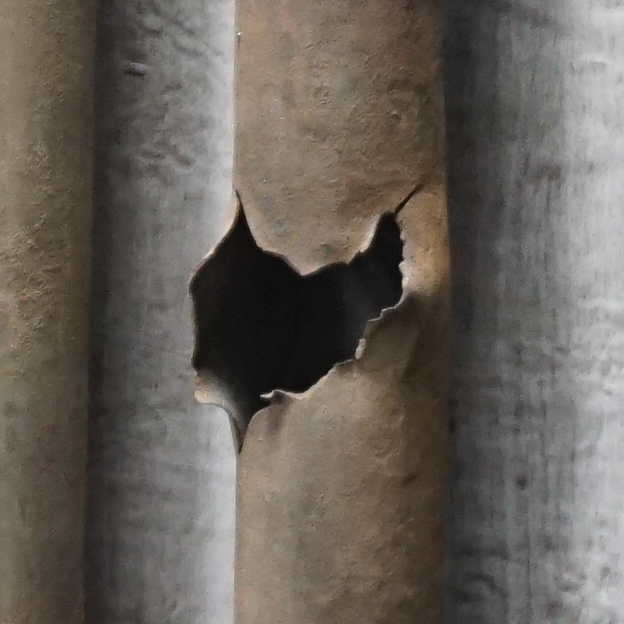

In [59]:
new_dataset[7]['image']

In [35]:
for i in range(len(new_dataset)):
    if i % 2 != 0:
        new_dataset[i]["image"].save(f"../dataset/pipe/for_stable_diffusion/croped/2/{i}_{new_dataset[i]['text'].split()[0]}.jpg")

# После удаления нерелевантных изображений формируем новый датасет

In [61]:
from glob import glob
from PIL import Image
import os
from tqdm import tqdm

In [62]:
total_dataset = []
for path in tqdm(glob('../dataset/pipe/for_stable_diffusion/croped/2/*')):
    i = int(os.path.basename(path).split('.')[0].split('_')[0])
    total_dataset.append(new_dataset[i - 1])
    total_dataset.append(new_dataset[i])

100%|██████████| 420/420 [00:20<00:00, 20.36it/s]


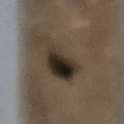

In [74]:
total_dataset[6]['image']

In [75]:
total_dataset[6]['text']

'Photo of a fistula on a metal pipe'

In [76]:
from datasets import Dataset
dataset = Dataset.from_list(total_dataset) # Загрузим датасет из списка в объект

dataset.save_to_disk('../dataset/promt_datasets/total/2') # Сохраним на диск датасе

In [78]:
from datasets import load_dataset
test_dataset = load_dataset("beans", split="train")


Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


In [79]:
test_dataset

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1034
})

In [80]:
dataset

Dataset({
    features: ['text', 'image'],
    num_rows: 840
})